In [1]:
from time import time
import networkx as nx
import pickle
import time
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import os
import torch
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm
from torch.utils.data import DataLoader
import torch.utils.data as Data
import numpy as np
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence
import math
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn.parameter import Parameter
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class args(object):
    
    #### DATA  ####
    num_colour = 10 
    node_size = num_colour + 1  # equals to the number of nodes + 1 (zero_padding) # number of colour + 1 for padding
    seq_len = 10
    
    #### Training ####
    batch_size = 128
    lr = 0.0002
    beta1 = 0.9
    beta2 = 0.999
    LSTM_maxnorm = 0.25
    acc_threshold = 0.5
    try_valid = 20
    running_loss = False
    n_epoch = 50
    weight_reg = 0
    
    
    
    #### Model ####
    RNN_model = 'lstm' # The hidden_size has to be a list if using nalu
    loss_type = 'Contrastive' # [Manhattan, Contrastive]
    margin = 1
    hidden_size = [512]
    num_layers = 5
    embedding_dim = 1024
    embedding_maxnorm = None
    bidirectional = False
    model_name = 'SimplestSiamese2' 
    model_path ='./'+ model_name +'/Model/'
    
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

'''
TODO:

'''   

# SimplePathWith10th5Colours.txt
# SimplestGraphWith20Nodes.txt
with open("SimplestGraphWith20Nodes_10000Pairs.txt", "rb") as fp:   # Unpickling
    df = pickle.load(fp)
X = df[['left','right']]     
Y = df['target']    
del df

#Seperate to training, validation, and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 64)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size= 0.05,random_state= 64)
Y_test = Y_test.values
Y_train = Y_train.values
Y_validation = Y_validation.values

#Check shape
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

def padding(data):
    left = [] 
    for i in range(data.shape[0]):
        left.append((data.iloc[i]['left']))
    right = [] 
    for i in range(data.shape[0]):
        right.append((data.iloc[i]['right']))
    return torch.tensor(np.array([right,left])).transpose(1,0)

def plot_train_hist(train_hist, step = None, ):
    fig = plt.figure(figsize=(20, 10))
    for name in train_hist.keys():
        if 'Loss' in name:
            plt.subplot(211)
            plt.plot(train_hist[name],marker='o',label= name)
            plt.ylabel('Loss',fontsize=15)
            plt.xlabel('Number of epochs',fontsize=15)
            plt.title('Loss',fontsize=20,fontweight ="bold")
            plt.legend(loc='upper left')
        else:
            plt.subplot(212)
            plt.plot(train_hist[name],marker='o',label= name)
            plt.ylabel('Accuracy',fontsize=15)
            plt.xlabel('Number of epochs',fontsize=15)
            plt.title('Accuracy',fontsize=20,fontweight ="bold")
            plt.legend(loc='upper left')
        
    plt.tight_layout()
    plt.show()
    if step is not None:
        fig.savefig("Train_Val_Hist"+str(step)+".png") 

def CreateDataset(X_left, X_right, Y):
    
    X_left_list = list(X_left)
    X_right_list = list(X_right)
    
    X_left_seq_len = torch.tensor(list(map(len, X_left_list)))
    X_right_seq_len = torch.tensor(list(map(len, X_right_list)))
    X_left_seq_len, X_left_len_idx = X_left_seq_len.sort(0,descending = True)
    X_right_seq_len, X_right_len_idx = X_right_seq_len.sort(0,descending = True)
    print('X_len',  X_left_seq_len , X_right_seq_len)
    X_left_ordered = [torch.LongTensor(X_left_list[i]) for i in X_left_len_idx]
    X_right_ordered = [torch.LongTensor(X_right_list[i]) for i in X_right_len_idx]
    X_left_p = pad_sequence(X_left_ordered, batch_first = True)
    X_right_p = pad_sequence(X_right_ordered, batch_first = True)
    Y = torch.FloatTensor(np.array(Y))
    train_dataset  = Data.TensorDataset(X_left_p, X_left_seq_len, X_right_p, X_right_seq_len, Y)
    
    return train_dataset


In [2]:
# # If it's not work, we can pad the seq to certain len.
# X_train_left_list = list(X_train['left'])
# X_train_right_list = list(X_train['right'])
# X_train_left_seq_len = torch.tensor(list(map(len, X_train_left_list)))
# X_train_right_seq_len = torch.tensor(list(map(len, X_train_right_list)))
# X_train_left_seq_len, X_train_left_len_idx = X_train_left_seq_len.sort(0,descending = True)
# X_train_right_seq_len, X_train_right_len_idx = X_train_right_seq_len.sort(0,descending = True)
# X_left_train_ordered = [torch.tensor(X_train_left_list[i]) for i in X_train_left_len_idx]
# X_right_train_ordered = [torch.tensor(X_train_right_list[i]) for i in X_train_right_len_idx]
# X_train_left = pad_sequence(X_left_train_ordered, batch_first = True)
# X_train_right = pad_sequence(X_right_train_ordered, batch_first = True)
# Y_train = torch.FloatTensor(np.array(Y_train))
# train_dataset  = Data.TensorDataset(X_train_left, X_train_right, Y_train)

In [3]:
# X_len = 36336
# X_train_list = list(X_train['left']) + list(X_train['right'])
# X_train_seq_len = torch.tensor(list(map(len, X_train_list)))
# X_train_seq_len, X_train_idx = X_train_seq_len.sort(0, descending= True)
# # the left and the right will be mixed after the sort operator 
# # Seperate the idx first and use the idx to choose the dordered list,
# left_idx = [ i for i in X_train_idx if i < X_len]
# right_idx = [ i for i in X_train_idx if i >= X_len]

In [4]:
train_dataset = CreateDataset(X_train['left'], X_train['right'], Y_train)
val_dataset = CreateDataset(X_validation['left'], X_validation['right'], Y_validation)
test_dataset = CreateDataset(X_test['left'], X_test['right'], Y_test)

X_len tensor([20, 20, 20,  ...,  3,  3,  3]) tensor([20, 20, 20,  ...,  2,  2,  2])
X_len tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16

In [5]:
print('Traninig data size: ', len(train_dataset))
print('Validation data size: ', len(val_dataset))
print('Test data size: ', len(test_dataset))

Traninig data size:  15200
Validation data size:  800
Test data size:  4000


In [6]:
# #Padding and creat the loaders
# X_train = padding(X_train)
# Y_train = torch.FloatTensor(np.array(Y_train))
# train_dataset  = Data.TensorDataset(X_train,Y_train)

# X_validation = padding(X_validation)
# Y_validation = torch.FloatTensor(np.array(Y_validation))
# val_dataset  = Data.TensorDataset(X_validation,Y_validation)

# X_test = padding(X_test)
# Y_test = torch.FloatTensor(np.array(Y_test))
# test_dataset  = Data.TensorDataset(X_test,Y_test)

In [7]:
class NeuralAccumulatorCell(nn.Module):
    
    # Feed forward but Weight decomposition
    
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.W_hat = Parameter(torch.Tensor(out_dim, in_dim))
        self.M_hat = Parameter(torch.Tensor(out_dim, in_dim))
        self.W = Parameter(torch.tanh(self.W_hat) * torch.sigmoid(self.M_hat))
        self.register_parameter('bias', None)

        init.kaiming_uniform_(self.W_hat, a=math.sqrt(5))
        init.kaiming_uniform_(self.M_hat, a=math.sqrt(5))
        
        #init.normal_(self.W_hat)
        #init.normal_(self.M_hat)
        
    def forward(self, input):
        return F.linear(input, self.W, self.bias)


class NAC(nn.Module):
    
    def __init__(self, dims):
        '''
        dims = [input_dim + hidden_dims + output_dims]
        '''
        super().__init__()
        self.num_layers = len(dims) - 1
        
        layers = nn.ModuleList()
        layers.extend([NeuralAccumulatorCell(dims[i],dims[i+1]) for i in range(self.num_layers)])
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out

class NeuralArithmeticLogicUnitCell(nn.Module):

    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.eps = 1e-10

        self.G = Parameter(torch.Tensor(out_dim, in_dim))
        self.W = Parameter(torch.Tensor(out_dim, in_dim))
        self.register_parameter('bias', None)
        self.nac = NeuralAccumulatorCell(in_dim, out_dim)

        init.kaiming_uniform_(self.G, a = math.sqrt(5))
        init.kaiming_uniform_(self.W, a = math.sqrt(5))

    def forward(self, input):
        
        a = self.nac(input)
        g = torch.sigmoid(F.linear(input, self.G, self.bias))
        add_sub = g * a
        log_input = torch.log(torch.abs(input) + self.eps)
        m = torch.exp(self.nac(log_input))
        # m = torch.exp(F.linear(log_input, self.W, self.bias))
        mul_div = (1 - g) * m
        y = add_sub + mul_div
        return y


class NALU(nn.Module):
    
    def __init__(self, dims):
        super().__init__()
        self.num_layers = len(dims) - 1
        layers = nn.ModuleList()
        layers.extend([NeuralArithmeticLogicUnitCell(dims[i],dims[i+1]) for i in range(self.num_layers)])
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out

class NALU_LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.i2h = nn.Sequential(
            nn.Linear(input_size, 4 * hidden_size, bias=bias),
            nn.BatchNorm1d(4 * hidden_size),
#             nn.LeakyReLU(0.2,inplace=True),
#             nn.Linear(4 *input_size, 4 * hidden_size, bias=bias),
        )
        self.h2h = nn.Sequential(
            nn.Linear(hidden_size, 4 * hidden_size, bias=bias),
           nn.BatchNorm1d(4 * hidden_size),
#             nn.LeakyReLU(0.2,inplace=True),
#             nn.Linear(4 * hidden_size, 4 * hidden_size, bias=bias)
        )
        self.nalu_h = NALU([hidden_size, hidden_size])
        self.nalu_c = NALU([hidden_size, hidden_size])
        self.out = nn.Linear(hidden_size, input_size, bias=bias)
        self.apply(self.weight_init)

    def weight_init(self,m):

        std = 1.0 / math.sqrt(self.hidden_size)
        for name, w in m.named_parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden = None):
        
        if hidden is None:
            hidden = x.new_zeros(x.size(0), self.hidden_size, requires_grad=False)
            hidden = (hidden, hidden)
            
        h, c = hidden
        
        preact = self.i2h(x) + self.h2h(h)
        
        # First: apply nalu to replace activation func
        
        # self.nalu(preact)
        
        gates = preact[:, :3 * self.hidden_size].sigmoid()
        g_t = preact[:, 3 * self.hidden_size:].tanh()
        i_t = gates[:, :self.hidden_size] 
        f_t = gates[:, self.hidden_size:2 * self.hidden_size]
        o_t = gates[:, -self.hidden_size:]
        
        # Second: Apply it in the output and hidden layer

        c_t = (c*f_t) + (i_t*g_t)

        h_t = o_t * c_t.tanh()
        
        # return x, (h_t, c_t) # LSTM
        
        # return x + self.out(h_t), (h_t + h, c_t + c) # Residule LSTM

        return  x + self.out(h_t) , (self.nalu_h(h_t + h), self.nalu_c(c_t + c)) # Residule NALU

class NALU_LSTM(nn.Module):
    
    def __init__(self,input_size, hidden_sizes, bidirectional = False):
        
        super().__init__()
        self.bidirectional = bidirectional
        
        if self.bidirectional:
            self.num_dir = 2
        else:
            self.num_dir = 1
            
        self.input_size = input_size
        self.L = len(hidden_sizes)
        self.layers = nn.ModuleList()
        self.layers.extend([NALU_LSTMCell(input_size,i) for i in hidden_sizes])
        self.c0 = nn.ParameterList([nn.Parameter(torch.randn(self.num_dir, 1,i)) for i in hidden_sizes])
        self.h0 = nn.ParameterList([nn.Parameter(torch.randn(self.num_dir, 1,i)) for i in hidden_sizes])
        
        
    def forward(self, input):
        
        '''
        input_shape = B, S, input_size
        output_shape = B, num_dir, L, S, input_size
        hidden, cells = S * (B, hidden_dim)
        '''
        
        B,S = input.shape[:-1]
        
        outputs = torch.zeros(B, self.num_dir, self.L+1, S, self.input_size)
        outputs[:,:,0,:,:] = input.unsqueeze(1).expand_as(outputs[:,:,0,:,:])
        hiddens = []
        cells = []
    
        for i, layer in enumerate(self.layers):
            f_h, f_c = self.h0[i][0].repeat(B,1), self.c0[i][0].repeat(B,1)
            if self.bidirectional:
                i_h, i_c = self.h0[i][1].repeat(B,1), self.c0[i][1].repeat(B,1)
            for j in range(S):
                f_out, (f_h,f_c) = layer(outputs[:,0,i,j,:].clone(), (f_h,f_c))
                outputs[:,0,i+1,j,:] = f_out

            if self.bidirectional:
                for j in reversed(range(S)):
                    i_out, (i_h,i_c) = layer(outputs[:,1,i,j,:].clone(), (i_h,i_c))
                    outputs[:,1,i+1,j,:] = i_out
                hiddens.append((torch.stack([f_h,i_h])))
                cells.append(torch.stack([f_c,i_c]))
            else:
                hiddens.append(f_h)
                cells.append(f_c)
                
        #outputs = outputs[:,:,-1:,:,:]
        return outputs[:,:,1:,:,:].contiguous(), (hiddens, cells)

In [8]:
class RNN_Encoder(nn.Module):
    def __init__(self, model = 'lstm'):
        super(RNN_Encoder, self).__init__()
        
        # No need for padding, but if we need the padding, we have to set the idx as 0
        # So that's why we need to make the graph start from 0
        self.model = model
        self.embedding = nn.Embedding(args.node_size, embedding_dim = args.embedding_dim, padding_idx=0,
                                      max_norm = args.embedding_maxnorm)
        

        if args.bidirectional:
            num_dir = 2
            fc_size1= args.hidden_size[-1]*args.seq_len*2
            fc_size2= 128
        else:
            num_dir = 1
            fc_size1= args.hidden_size[-1]
            fc_size2= 16
            
        self.fc= nn.Sequential(
            nn.Linear(fc_size1,fc_size2),
            nn.BatchNorm1d(fc_size2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(fc_size2,2),
        )
        
        
        if self.model == 'lstm':
            self.rnn = nn.LSTM(input_size = args.embedding_dim, hidden_size = args.hidden_size[-1],
                           num_layers = args.num_layers, bidirectional = args.bidirectional, batch_first = True)
            self.h0 = nn.Parameter(torch.randn(args.num_layers*num_dir, 1, args.hidden_size[-1]))
            self.c0 = nn.Parameter(torch.ones(args.num_layers*num_dir, 1, args.hidden_size[-1]))
            print('Using LSTM')
        elif self.model == 'gru':
            self.h0 = nn.Parameter(torch.randn(args.num_layers*num_dir, 1, args.hidden_size[-1]))
            self.rnn = nn.GRU(input_size= args.embedding_dim, hidden_size= args.hidden_size[-1],
                              num_layers = args.num_layers, bidirectional = args.bidirectional, batch_first = True)
            print('Using GRU')
            
        elif self.model == 'nalu':
            self.rnn = NALU_LSTM(args.embedding_dim, args.hidden_size, bidirectional= args.bidirectional)
            print('Using NALU')
        else:
            raise NotImplementedError

        
    def forward(self, x, lengths = None):
        
        B = x.size(0)
        
        out = self.embedding(x)
        
        if self.model == 'lstm':
            h_ = (self.h0.repeat(1,B,1), self.c0.repeat(1,B,1))
        elif self.model == 'gru':
            h_ = self.h0.repeat(1,B,1)
        if self.model =='nalu':
            out, hidden = self.rnn(out)
            out = out[:,:,-1,:,:].squeeze() 
        else:
            out = pack_padded_sequence(out, lengths, batch_first = True)
            out, hidden = self.rnn(out, h_)
            out, unpacked_len = pad_packed_sequence(out, batch_first=True)
        
        if args.bidirectional:
            out = self.fc(out.contiguous().view(B,-1))
        else:
            out = self.fc(out[:,-1,:])
        return out
    
    

class SiameseNet(nn.Module):
    def __init__(self,):
        super(SiameseNet, self).__init__()
        
        self.encoder = RNN_Encoder(args.RNN_model)
        self.mse = nn.MSELoss()
        self.train_hist = defaultdict(list)
        self.acc_hist = []
        self.apply(self.weight_init)
        
        self.optim = optim.Adam(self.encoder.parameters(), lr = args.lr, betas= (args.beta1, args.beta2),
                                weight_decay = args.weight_reg)
        
    def forward(self, left, left_len, right, right_len, y):
        
        self.optim.zero_grad()
        
        left_out = self.encoder(left, left_len)
        right_out = self.encoder(right, right_len)
        
        if args.loss_type == "Manhattan":
            self.prediction = torch.exp(-torch.norm((left_out - right_out),1,-1))
            self.loss = self.mse(self.prediction, y)
            self.acc = torch.mean(((self.prediction>args.acc_threshold) == (y.byte())).float())
            
        elif args.loss_type == "Contrastive":
            self.distances = (left_out - right_out).pow(2).sum(1).sqrt()  # squared distances
            self.prediction = self.distances <= args.margin # < margin is the positive pair, which means they're close to each other
            self.loss = (0.5 * (y * self.distances +\
                            (1 + -1 * y) * torch.clamp(args.margin - self.distances, min=0.0).pow(2))).mean()
            self.acc = torch.mean((self.prediction == y.byte()).float())
        else:
            raise NotImplementedError
            
        self.take = left_out - right_out
        
        if args.LSTM_maxnorm is not None:
            nn.utils.clip_grad_norm_(self.encoder.rnn.parameters(), args.LSTM_maxnorm)
        
        self.train_hist['Loss'].append(self.loss.item())
        self.train_hist['Accuracy'].append(self.acc.item())
        self.loss.backward()
        self.optim.step()
        
    def weight_init(self,m):
        if type(m) in [nn.Conv2d, nn.ConvTranspose2d, nn.Linear]:
            nn.init.kaiming_normal_(m.weight,0.2,nonlinearity='leaky_relu')
        elif type(m) in [nn.LSTM]:
            for name, value in m.named_parameters():
                if 'weight' in name :
                    nn.init.xavier_normal_(value.data)
                if 'bias'in name:
                    value.data.normal_()
                    
    def model_save(self,step):
        
        path = args.model_path + args.model_name+'_Step_' + str(step) + '.pth'
        torch.save({args.model_name:self.state_dict()}, path)
        print('Model Saved')
        
    def load_step_dict(self, step):
        
        path = args.model_path + args.model_name +'_Step_' + str(step) + '.pth'
        self.load_state_dict(torch.load(path, map_location = lambda storage, loc: storage)[args.model_name])
        print('Model Loaded')
        
    def plot_all_loss(self, step):
        fig = plt.figure(figsize=(20, 10))
        num_loss = 2
        i = 0
        for name in self.train_hist.keys():
            if 'V' not in name:
                i+= 1
                fig.add_subplot(num_loss,1,i)
                plt.plot(self.train_hist[name], label = name)
                plt.xlabel('Number of Steps',fontsize=15)
                plt.ylabel( name, fontsize=15)
                plt.title(name, fontsize=30, fontweight ="bold")
                plt.legend(loc = 'upper left')
        plt.tight_layout()
        plt.show()
        fig.savefig("Train_Hist"+str(step)+".png") 
        
    def test_step(self, left, left_len, right, right_len, y):
        
        
        left_out = self.encoder(left, left_len)
        right_out = self.encoder(right, right_len)
        
        self.v_prediction = torch.exp(-torch.norm((left_out - right_out),1,-1)).detach()
        self.v_loss = self.mse(self.v_prediction, y)
        self.v_acc = torch.mean(((self.v_prediction>args.acc_threshold) == (y.byte())).float())
        self.train_hist['V_Loss'].append(self.v_loss.item())
        self.train_hist['V_Accuracy'].append(self.v_acc.item())    

In [9]:
train_loader = DataLoader(train_dataset, batch_size = args.batch_size, shuffle=False, drop_last = True)
valid_loader = DataLoader(val_dataset, batch_size = args.batch_size, shuffle=False, drop_last= True)

In [10]:
args.weight_reg = 0
args.RNN_model = 'lstm'
siamese = SiameseNet().to(device)
siamese.train()
scheduler = optim.lr_scheduler.StepLR(siamese.optim, 2000, gamma=0.7)
siamese.optim.param_groups[0]['lr']= 0.0002

Using LSTM


In [11]:
train_hist = defaultdict(list)
args.running_loss = True
args.n_epoch = 50
all_step = 0
epoch = 0

| Epoch [0] | Step [1] | lr [0.000200] | Loss: [0.2167] | Acc: [0.5547] | Time: 0.2s
| Epoch [0] | Step [2] | lr [0.000200] | Loss: [0.2444] | Acc: [0.5000] | Time: 0.2s
| Epoch [0] | Step [3] | lr [0.000200] | Loss: [0.2011] | Acc: [0.4922] | Time: 0.2s
| Epoch [0] | Step [4] | lr [0.000200] | Loss: [0.1954] | Acc: [0.4609] | Time: 0.2s
| Epoch [0] | Step [5] | lr [0.000200] | Loss: [0.1838] | Acc: [0.5078] | Time: 0.2s
| Epoch [0] | Step [6] | lr [0.000200] | Loss: [0.2082] | Acc: [0.5156] | Time: 0.2s
| Epoch [0] | Step [7] | lr [0.000200] | Loss: [0.2272] | Acc: [0.5234] | Time: 0.2s
| Epoch [0] | Step [8] | lr [0.000200] | Loss: [0.2068] | Acc: [0.4844] | Time: 0.2s
| Epoch [0] | Step [9] | lr [0.000200] | Loss: [0.2082] | Acc: [0.5156] | Time: 0.2s
| Epoch [0] | Step [10] | lr [0.000200] | Loss: [0.2004] | Acc: [0.5000] | Time: 0.2s
| Epoch [0] | Step [11] | lr [0.000200] | Loss: [0.2105] | Acc: [0.5547] | Time: 0.2s
| Epoch [0] | Step [12] | lr [0.000200] | Loss: [0.2242] | Acc:

| Epoch [0] | Step [97] | lr [0.000200] | Loss: [0.2083] | Acc: [0.4531] | Time: 0.1s
| Epoch [0] | Step [98] | lr [0.000200] | Loss: [0.1760] | Acc: [0.5078] | Time: 0.1s
| Epoch [0] | Step [99] | lr [0.000200] | Loss: [0.2043] | Acc: [0.5000] | Time: 0.1s
| Epoch [0] | Step [100] | lr [0.000200] | Loss: [0.1984] | Acc: [0.5000] | Time: 0.1s
| Epoch [0] | Step [101] | lr [0.000200] | Loss: [0.2090] | Acc: [0.4688] | Time: 0.1s
| Epoch [0] | Step [102] | lr [0.000200] | Loss: [0.1982] | Acc: [0.5703] | Time: 0.1s
| Epoch [0] | Step [103] | lr [0.000200] | Loss: [0.2019] | Acc: [0.4844] | Time: 0.1s
| Epoch [0] | Step [104] | lr [0.000200] | Loss: [0.2040] | Acc: [0.4766] | Time: 0.1s
| Epoch [0] | Step [105] | lr [0.000200] | Loss: [0.2063] | Acc: [0.5156] | Time: 0.1s
| Epoch [0] | Step [106] | lr [0.000200] | Loss: [0.2019] | Acc: [0.4922] | Time: 0.1s
| Epoch [0] | Step [107] | lr [0.000200] | Loss: [0.1972] | Acc: [0.4375] | Time: 0.1s
| Epoch [0] | Step [108] | lr [0.000200] | Los

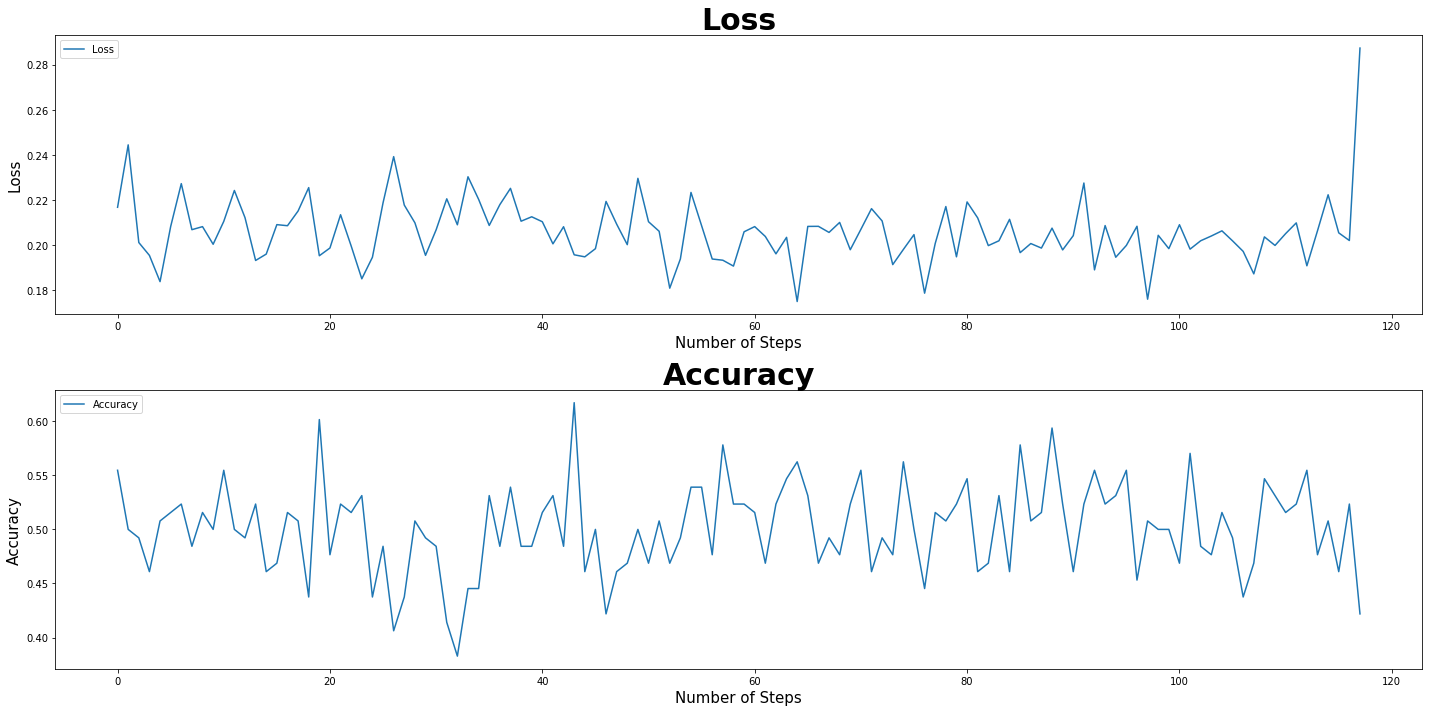

| Epoch [1] | Step [119] | lr [0.000200] | Loss: [0.1941] | Acc: [0.5547] | Time: 0.2s
| Epoch [1] | Step [120] | lr [0.000200] | Loss: [0.2377] | Acc: [0.5234] | Time: 0.2s
| Epoch [1] | Step [121] | lr [0.000200] | Loss: [0.1898] | Acc: [0.4922] | Time: 0.2s
| Epoch [1] | Step [122] | lr [0.000200] | Loss: [0.2063] | Acc: [0.4062] | Time: 0.2s
| Epoch [1] | Step [123] | lr [0.000200] | Loss: [0.1866] | Acc: [0.5078] | Time: 0.2s
| Epoch [1] | Step [124] | lr [0.000200] | Loss: [0.1994] | Acc: [0.5156] | Time: 0.2s
| Epoch [1] | Step [125] | lr [0.000200] | Loss: [0.2278] | Acc: [0.5234] | Time: 0.2s
| Epoch [1] | Step [126] | lr [0.000200] | Loss: [0.1937] | Acc: [0.4844] | Time: 0.2s
| Epoch [1] | Step [127] | lr [0.000200] | Loss: [0.1950] | Acc: [0.5156] | Time: 0.2s
| Epoch [1] | Step [128] | lr [0.000200] | Loss: [0.2062] | Acc: [0.4922] | Time: 0.2s
| Epoch [1] | Step [129] | lr [0.000200] | Loss: [0.2065] | Acc: [0.5000] | Time: 0.2s
| Epoch [1] | Step [130] | lr [0.000200] | 

| Epoch [1] | Step [215] | lr [0.000200] | Loss: [0.2012] | Acc: [0.4531] | Time: 0.1s
| Epoch [1] | Step [216] | lr [0.000200] | Loss: [0.2068] | Acc: [0.5156] | Time: 0.1s
| Epoch [1] | Step [217] | lr [0.000200] | Loss: [0.2293] | Acc: [0.5156] | Time: 0.1s
| Epoch [1] | Step [218] | lr [0.000200] | Loss: [0.1896] | Acc: [0.5000] | Time: 0.1s
| Epoch [1] | Step [219] | lr [0.000200] | Loss: [0.1886] | Acc: [0.4922] | Time: 0.1s
| Epoch [1] | Step [220] | lr [0.000200] | Loss: [0.1998] | Acc: [0.5703] | Time: 0.1s
| Epoch [1] | Step [221] | lr [0.000200] | Loss: [0.2202] | Acc: [0.4766] | Time: 0.1s
| Epoch [1] | Step [222] | lr [0.000200] | Loss: [0.1827] | Acc: [0.4922] | Time: 0.1s
| Epoch [1] | Step [223] | lr [0.000200] | Loss: [0.1964] | Acc: [0.5078] | Time: 0.1s
| Epoch [1] | Step [224] | lr [0.000200] | Loss: [0.2035] | Acc: [0.5156] | Time: 0.1s
| Epoch [1] | Step [225] | lr [0.000200] | Loss: [0.2017] | Acc: [0.4297] | Time: 0.1s
| Epoch [1] | Step [226] | lr [0.000200] | 

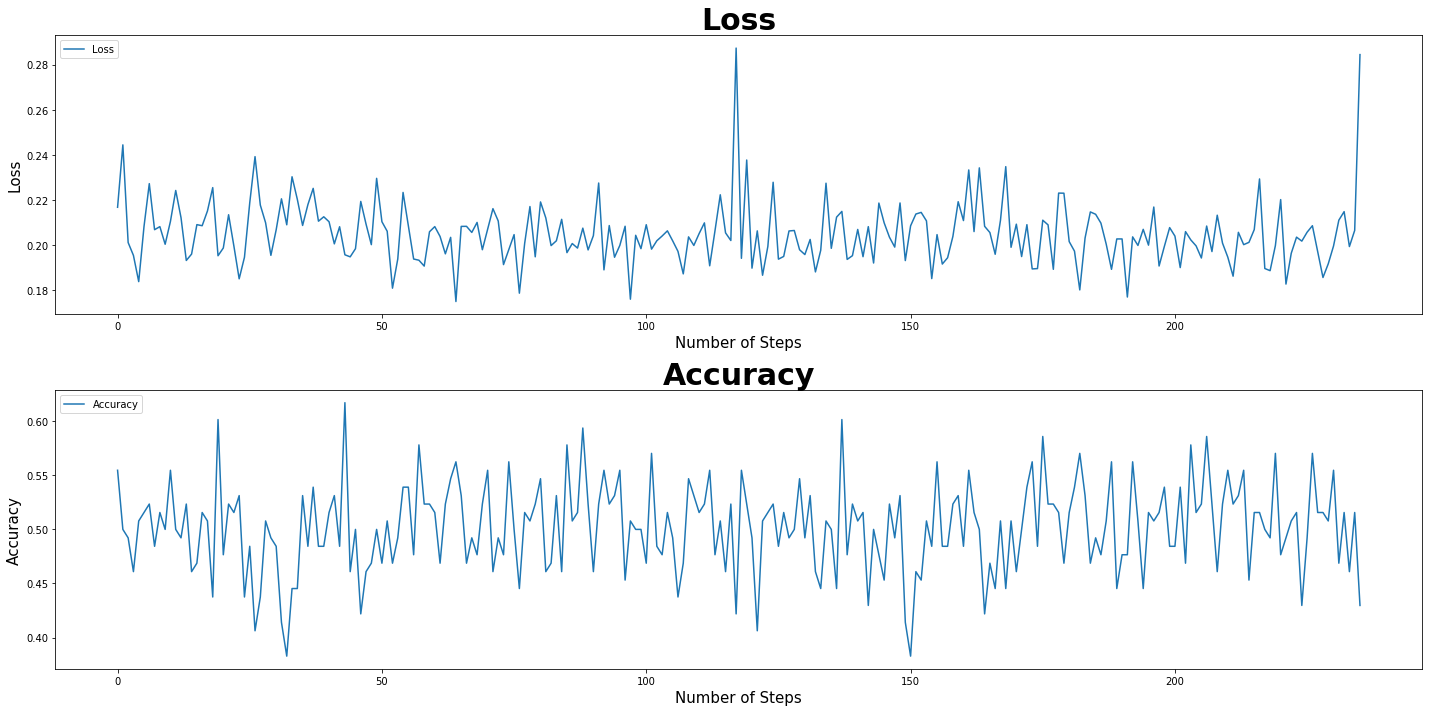

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


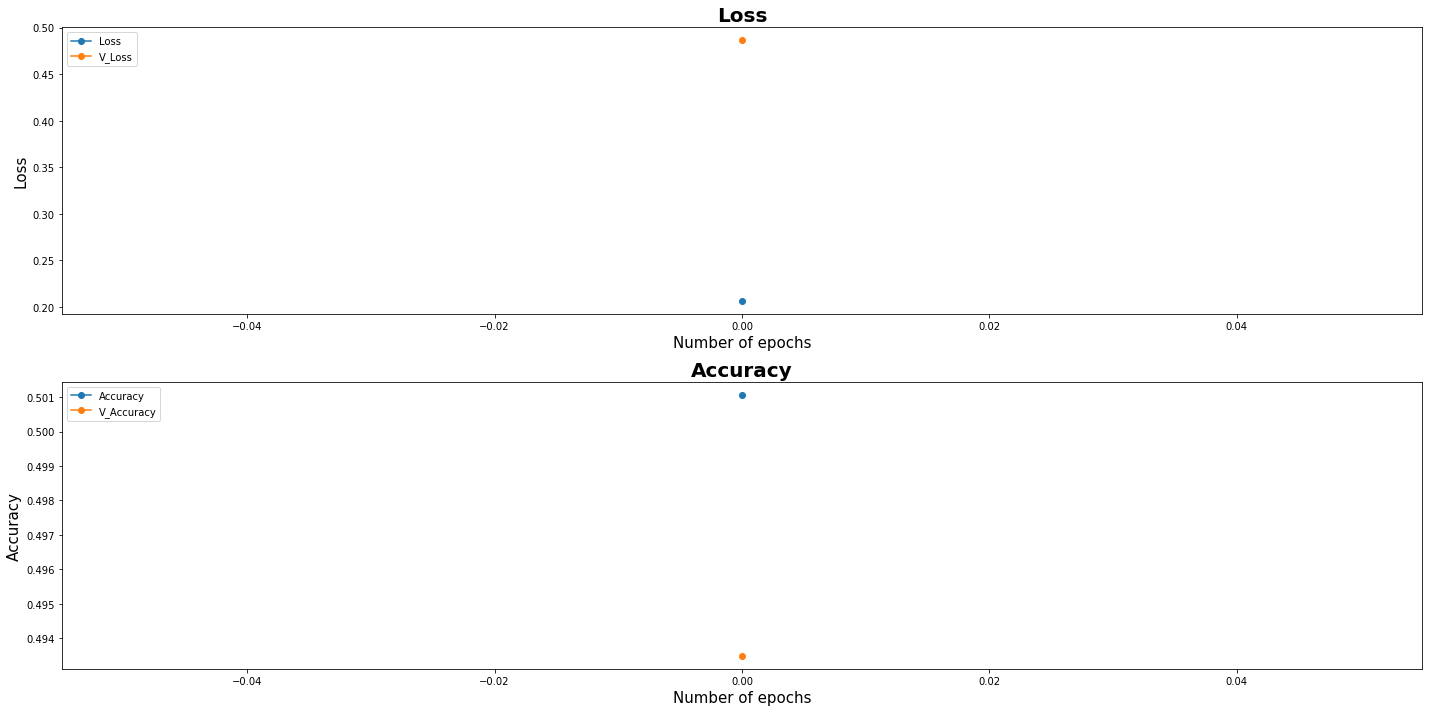

| Epoch [2] | Step [237] | lr [0.000200] | Loss: [0.1989] | Acc: [0.5625] | Time: 0.2s
| Epoch [2] | Step [238] | lr [0.000200] | Loss: [0.2408] | Acc: [0.5234] | Time: 0.2s
| Epoch [2] | Step [239] | lr [0.000200] | Loss: [0.1927] | Acc: [0.5000] | Time: 0.2s
| Epoch [2] | Step [240] | lr [0.000200] | Loss: [0.1977] | Acc: [0.4141] | Time: 0.2s
| Epoch [2] | Step [241] | lr [0.000200] | Loss: [0.2004] | Acc: [0.5078] | Time: 0.2s
| Epoch [2] | Step [242] | lr [0.000200] | Loss: [0.1941] | Acc: [0.5156] | Time: 0.2s
| Epoch [2] | Step [243] | lr [0.000200] | Loss: [0.2274] | Acc: [0.5312] | Time: 0.2s
| Epoch [2] | Step [244] | lr [0.000200] | Loss: [0.1838] | Acc: [0.4844] | Time: 0.2s
| Epoch [2] | Step [245] | lr [0.000200] | Loss: [0.2081] | Acc: [0.5156] | Time: 0.2s
| Epoch [2] | Step [246] | lr [0.000200] | Loss: [0.2072] | Acc: [0.4922] | Time: 0.2s
| Epoch [2] | Step [247] | lr [0.000200] | Loss: [0.2149] | Acc: [0.5000] | Time: 0.2s
| Epoch [2] | Step [248] | lr [0.000200] | 

| Epoch [2] | Step [333] | lr [0.000200] | Loss: [0.2109] | Acc: [0.4531] | Time: 0.1s
| Epoch [2] | Step [334] | lr [0.000200] | Loss: [0.1846] | Acc: [0.5156] | Time: 0.1s
| Epoch [2] | Step [335] | lr [0.000200] | Loss: [0.2134] | Acc: [0.5000] | Time: 0.1s
| Epoch [2] | Step [336] | lr [0.000200] | Loss: [0.2030] | Acc: [0.4922] | Time: 0.1s
| Epoch [2] | Step [337] | lr [0.000200] | Loss: [0.2104] | Acc: [0.4688] | Time: 0.1s
| Epoch [2] | Step [338] | lr [0.000200] | Loss: [0.1983] | Acc: [0.5703] | Time: 0.1s
| Epoch [2] | Step [339] | lr [0.000200] | Loss: [0.2127] | Acc: [0.4688] | Time: 0.1s
| Epoch [2] | Step [340] | lr [0.000200] | Loss: [0.1728] | Acc: [0.4844] | Time: 0.1s
| Epoch [2] | Step [341] | lr [0.000200] | Loss: [0.2029] | Acc: [0.5234] | Time: 0.1s
| Epoch [2] | Step [342] | lr [0.000200] | Loss: [0.1966] | Acc: [0.4922] | Time: 0.1s
| Epoch [2] | Step [343] | lr [0.000200] | Loss: [0.1856] | Acc: [0.4453] | Time: 0.1s
| Epoch [2] | Step [344] | lr [0.000200] | 

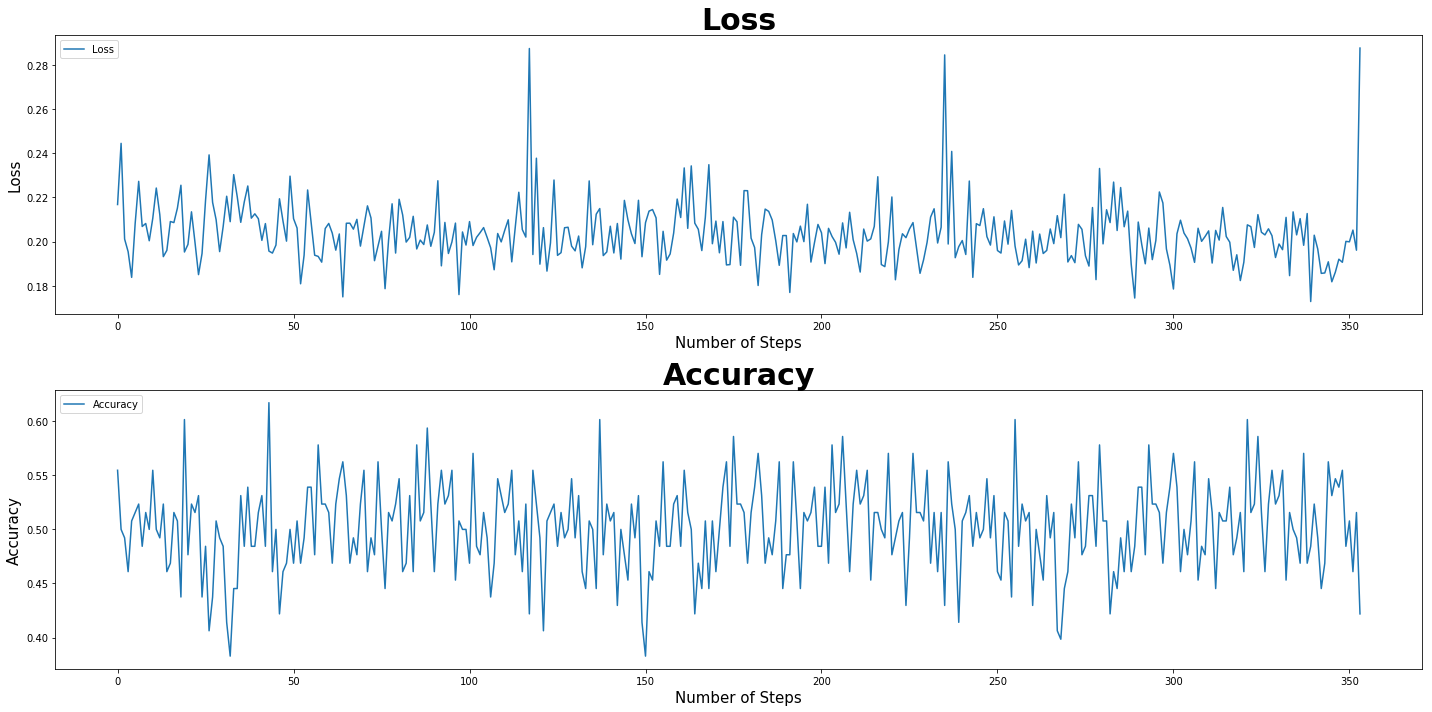

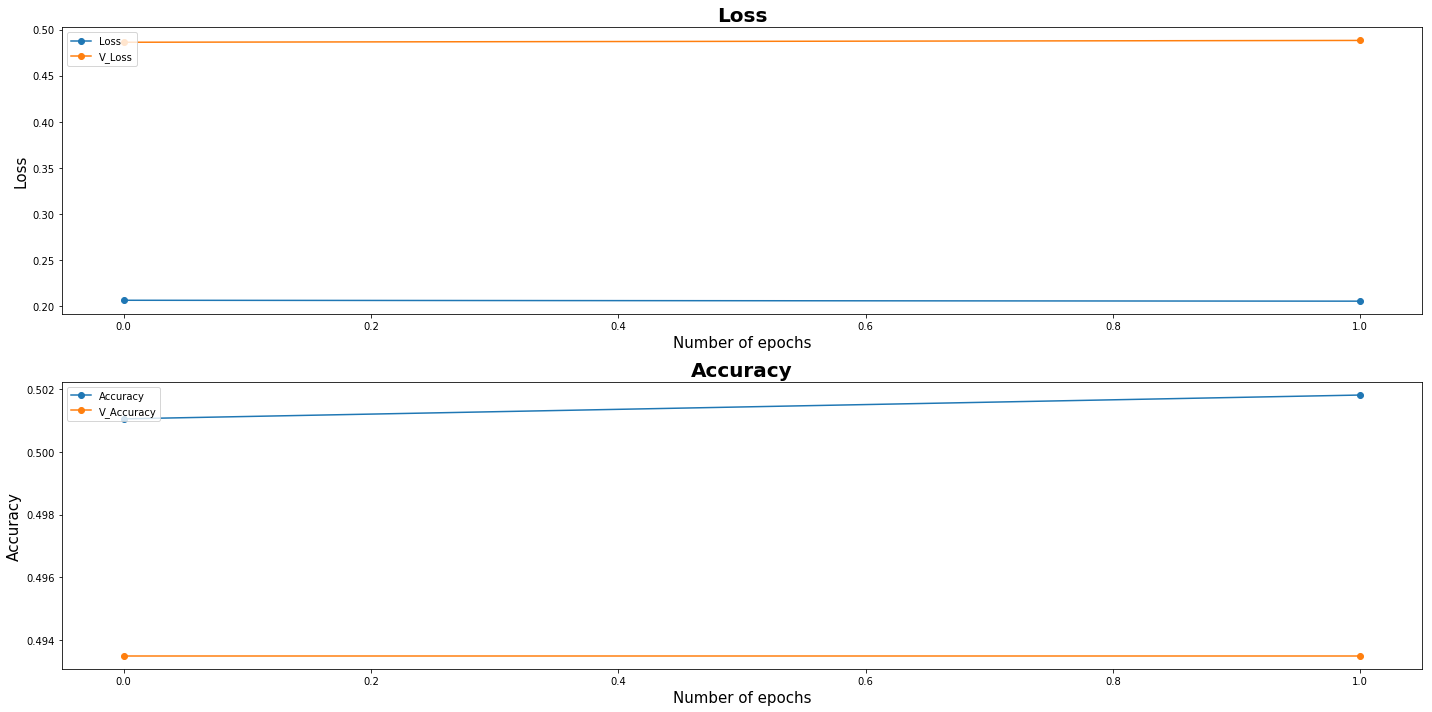

| Epoch [3] | Step [355] | lr [0.000200] | Loss: [0.1927] | Acc: [0.5547] | Time: 0.2s
| Epoch [3] | Step [356] | lr [0.000200] | Loss: [0.2382] | Acc: [0.5234] | Time: 0.2s
| Epoch [3] | Step [357] | lr [0.000200] | Loss: [0.1792] | Acc: [0.4922] | Time: 0.2s
| Epoch [3] | Step [358] | lr [0.000200] | Loss: [0.1833] | Acc: [0.4141] | Time: 0.2s
| Epoch [3] | Step [359] | lr [0.000200] | Loss: [0.1867] | Acc: [0.5078] | Time: 0.2s
| Epoch [3] | Step [360] | lr [0.000200] | Loss: [0.1940] | Acc: [0.5156] | Time: 0.2s
| Epoch [3] | Step [361] | lr [0.000200] | Loss: [0.2220] | Acc: [0.5391] | Time: 0.2s
| Epoch [3] | Step [362] | lr [0.000200] | Loss: [0.1798] | Acc: [0.4844] | Time: 0.2s
| Epoch [3] | Step [363] | lr [0.000200] | Loss: [0.1996] | Acc: [0.5156] | Time: 0.2s
| Epoch [3] | Step [364] | lr [0.000200] | Loss: [0.2035] | Acc: [0.4922] | Time: 0.2s
| Epoch [3] | Step [365] | lr [0.000200] | Loss: [0.2096] | Acc: [0.5000] | Time: 0.2s
| Epoch [3] | Step [366] | lr [0.000200] | 

| Epoch [3] | Step [451] | lr [0.000200] | Loss: [0.1909] | Acc: [0.4609] | Time: 0.1s
| Epoch [3] | Step [452] | lr [0.000200] | Loss: [0.1908] | Acc: [0.5156] | Time: 0.1s
| Epoch [3] | Step [453] | lr [0.000200] | Loss: [0.2083] | Acc: [0.5000] | Time: 0.1s
| Epoch [3] | Step [454] | lr [0.000200] | Loss: [0.2048] | Acc: [0.4922] | Time: 0.1s
| Epoch [3] | Step [455] | lr [0.000200] | Loss: [0.1774] | Acc: [0.4688] | Time: 0.1s
| Epoch [3] | Step [456] | lr [0.000200] | Loss: [0.1992] | Acc: [0.5703] | Time: 0.1s
| Epoch [3] | Step [457] | lr [0.000200] | Loss: [0.2038] | Acc: [0.4688] | Time: 0.1s
| Epoch [3] | Step [458] | lr [0.000200] | Loss: [0.1837] | Acc: [0.4844] | Time: 0.1s
| Epoch [3] | Step [459] | lr [0.000200] | Loss: [0.2032] | Acc: [0.5234] | Time: 0.1s
| Epoch [3] | Step [460] | lr [0.000200] | Loss: [0.1977] | Acc: [0.4844] | Time: 0.1s
| Epoch [3] | Step [461] | lr [0.000200] | Loss: [0.1865] | Acc: [0.4531] | Time: 0.1s
| Epoch [3] | Step [462] | lr [0.000200] | 

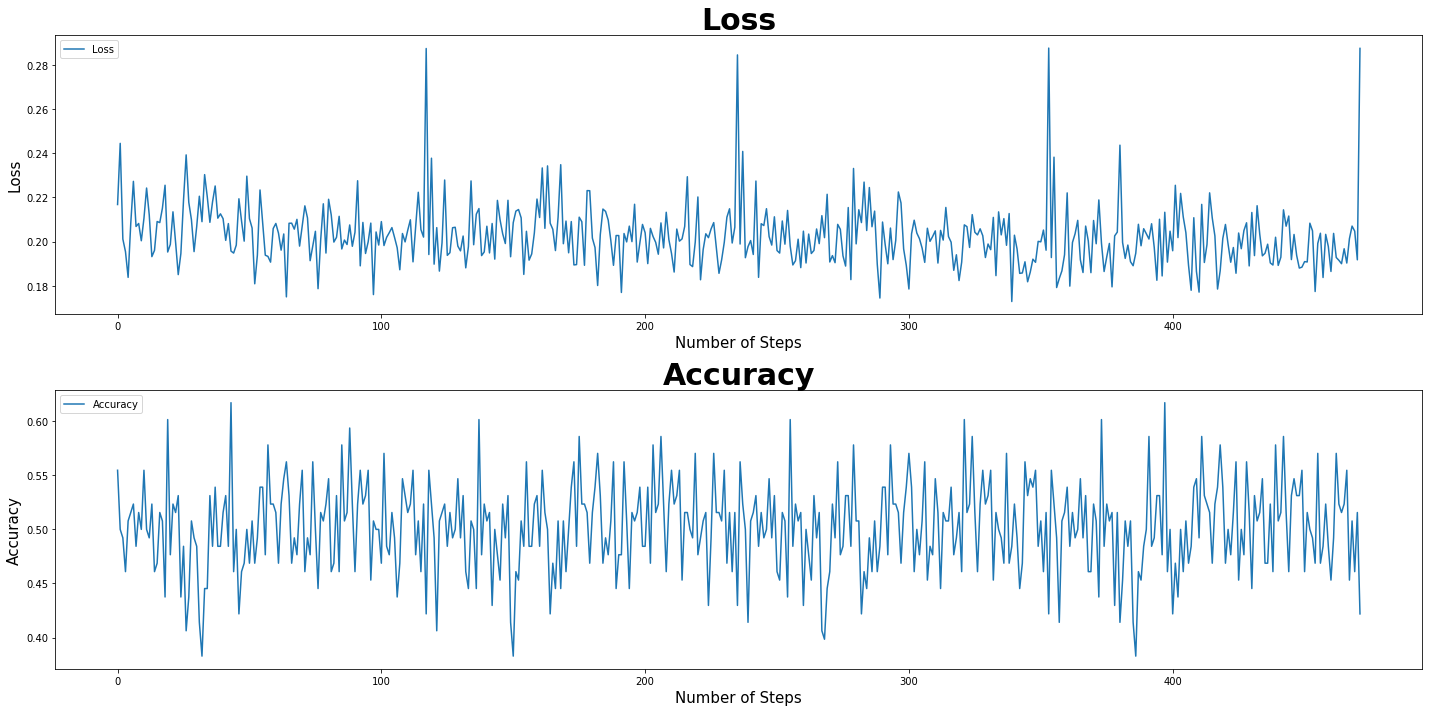

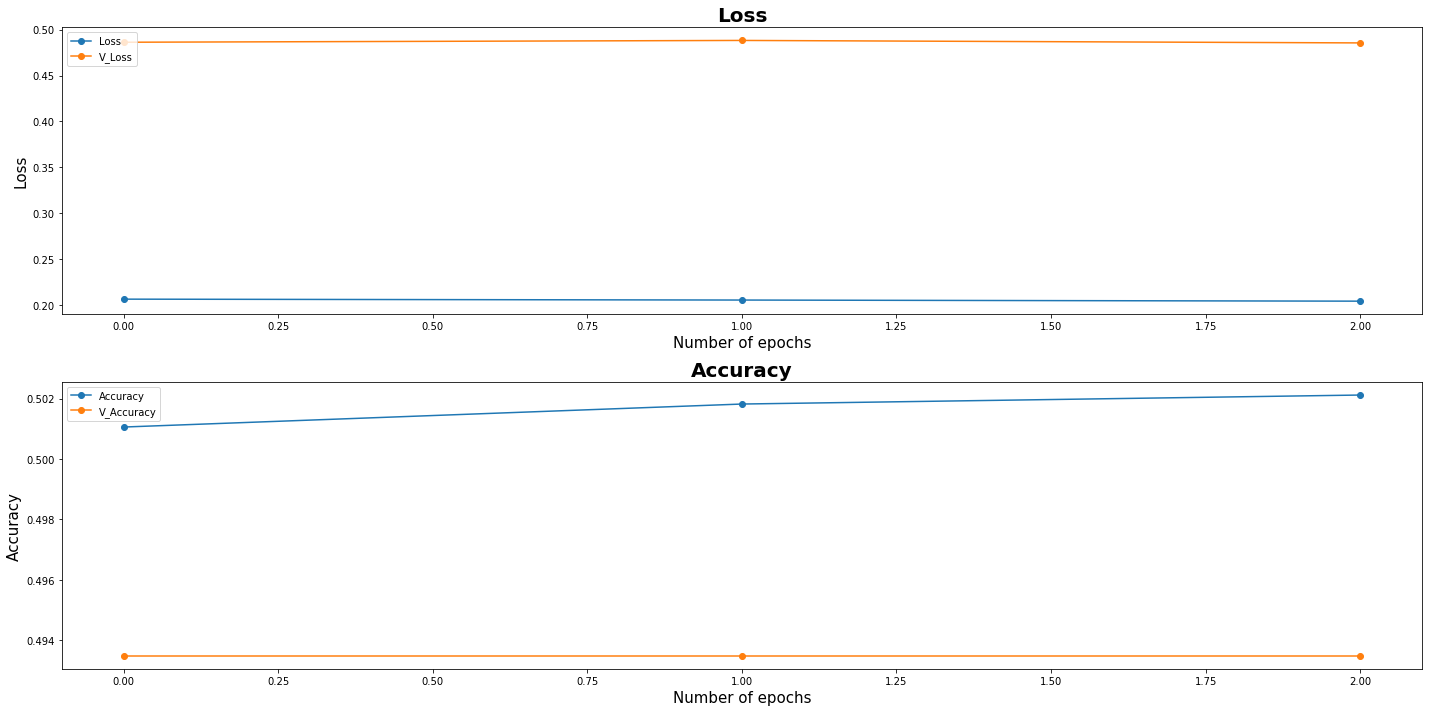

| Epoch [4] | Step [473] | lr [0.000200] | Loss: [0.1915] | Acc: [0.5547] | Time: 0.2s
| Epoch [4] | Step [474] | lr [0.000200] | Loss: [0.2383] | Acc: [0.5234] | Time: 0.2s
| Epoch [4] | Step [475] | lr [0.000200] | Loss: [0.1752] | Acc: [0.5078] | Time: 0.2s
| Epoch [4] | Step [476] | lr [0.000200] | Loss: [0.1840] | Acc: [0.4141] | Time: 0.2s
| Epoch [4] | Step [477] | lr [0.000200] | Loss: [0.1874] | Acc: [0.5078] | Time: 0.2s
| Epoch [4] | Step [478] | lr [0.000200] | Loss: [0.1994] | Acc: [0.5078] | Time: 0.2s
| Epoch [4] | Step [479] | lr [0.000200] | Loss: [0.2144] | Acc: [0.5469] | Time: 0.2s
| Epoch [4] | Step [480] | lr [0.000200] | Loss: [0.1831] | Acc: [0.4844] | Time: 0.2s
| Epoch [4] | Step [481] | lr [0.000200] | Loss: [0.1972] | Acc: [0.5156] | Time: 0.2s
| Epoch [4] | Step [482] | lr [0.000200] | Loss: [0.1986] | Acc: [0.4922] | Time: 0.2s
| Epoch [4] | Step [483] | lr [0.000200] | Loss: [0.2083] | Acc: [0.5000] | Time: 0.2s
| Epoch [4] | Step [484] | lr [0.000200] | 

| Epoch [4] | Step [569] | lr [0.000200] | Loss: [0.1930] | Acc: [0.4531] | Time: 0.1s
| Epoch [4] | Step [570] | lr [0.000200] | Loss: [0.1991] | Acc: [0.5156] | Time: 0.1s
| Epoch [4] | Step [571] | lr [0.000200] | Loss: [0.2120] | Acc: [0.5000] | Time: 0.1s
| Epoch [4] | Step [572] | lr [0.000200] | Loss: [0.2012] | Acc: [0.4922] | Time: 0.1s
| Epoch [4] | Step [573] | lr [0.000200] | Loss: [0.1869] | Acc: [0.4609] | Time: 0.1s
| Epoch [4] | Step [574] | lr [0.000200] | Loss: [0.1978] | Acc: [0.5703] | Time: 0.1s
| Epoch [4] | Step [575] | lr [0.000200] | Loss: [0.2038] | Acc: [0.4688] | Time: 0.1s
| Epoch [4] | Step [576] | lr [0.000200] | Loss: [0.1885] | Acc: [0.4766] | Time: 0.1s
| Epoch [4] | Step [577] | lr [0.000200] | Loss: [0.2044] | Acc: [0.5234] | Time: 0.1s
| Epoch [4] | Step [578] | lr [0.000200] | Loss: [0.1910] | Acc: [0.4922] | Time: 0.1s
| Epoch [4] | Step [579] | lr [0.000200] | Loss: [0.1902] | Acc: [0.4453] | Time: 0.1s
| Epoch [4] | Step [580] | lr [0.000200] | 

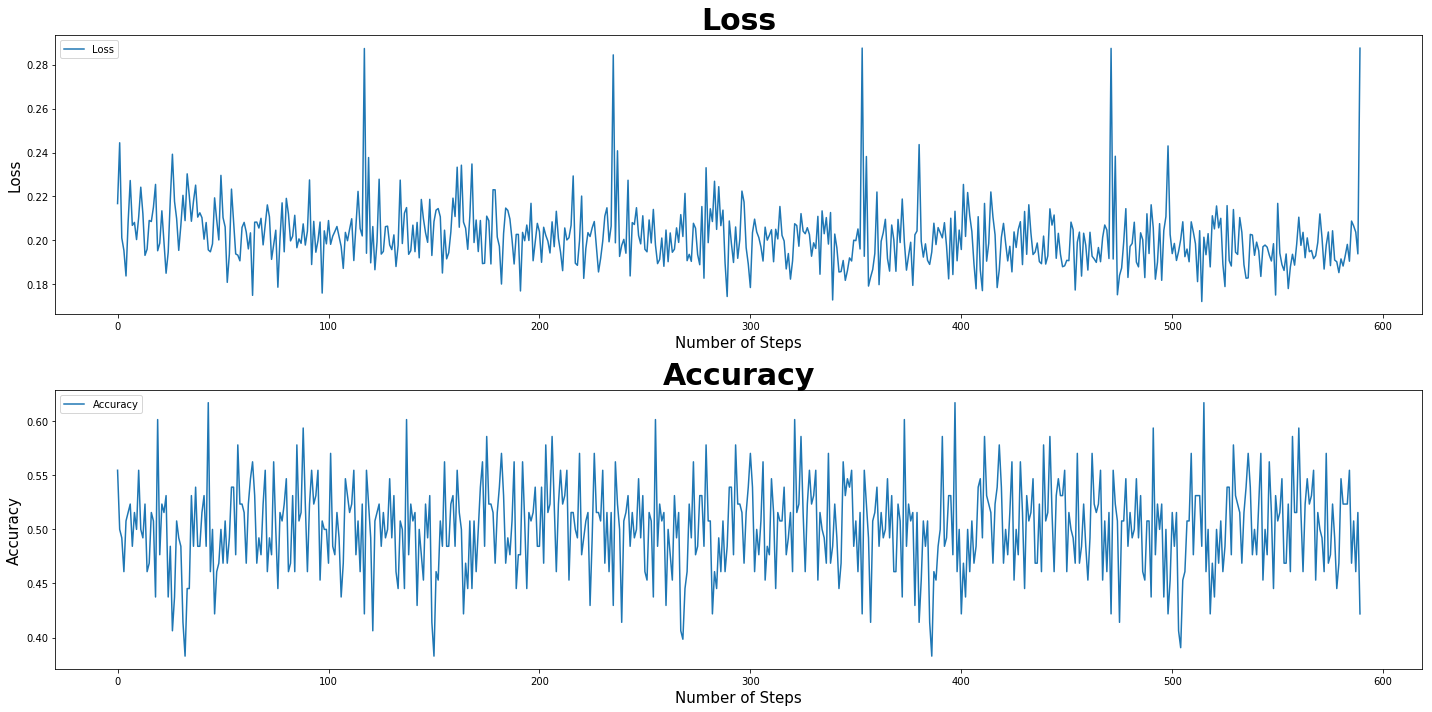

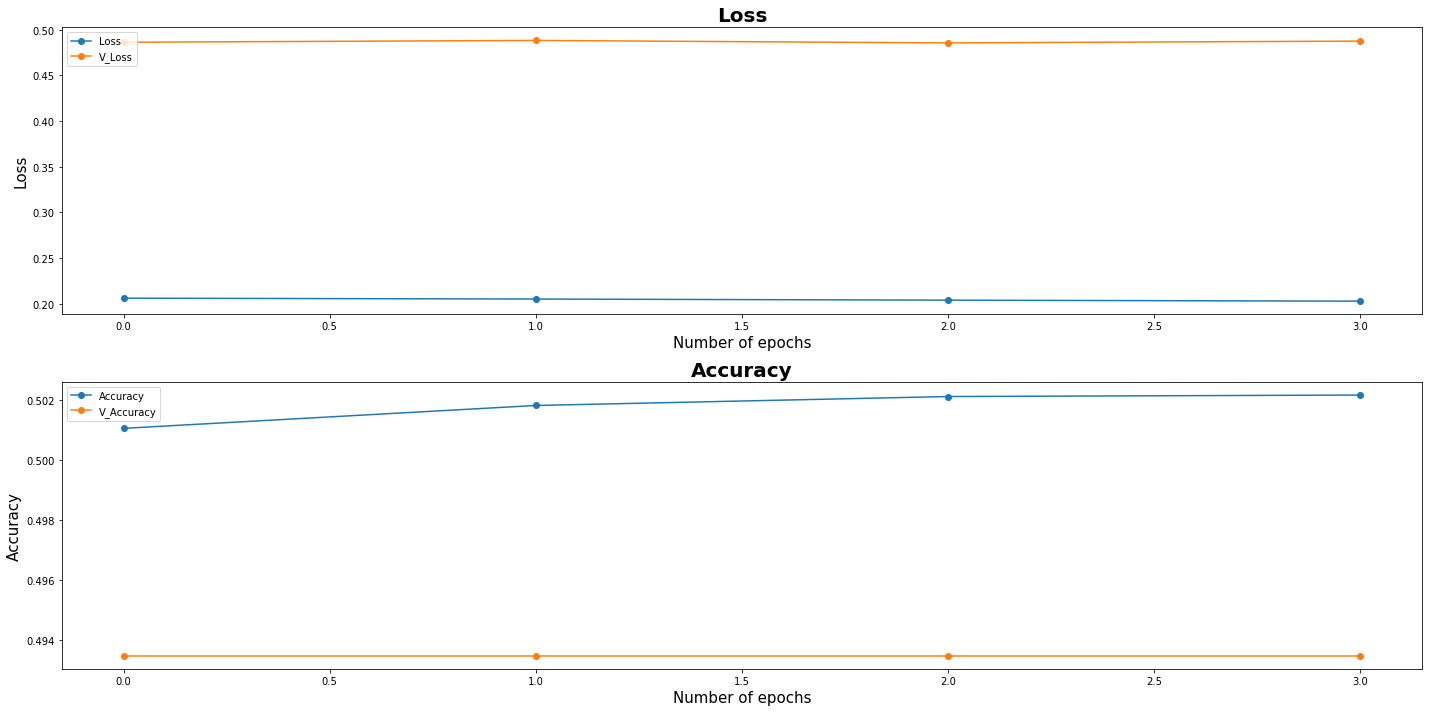

| Epoch [5] | Step [591] | lr [0.000200] | Loss: [0.1925] | Acc: [0.5625] | Time: 0.2s
| Epoch [5] | Step [592] | lr [0.000200] | Loss: [0.2386] | Acc: [0.5234] | Time: 0.2s
| Epoch [5] | Step [593] | lr [0.000200] | Loss: [0.1706] | Acc: [0.5000] | Time: 0.2s
| Epoch [5] | Step [594] | lr [0.000200] | Loss: [0.1859] | Acc: [0.4297] | Time: 0.2s
| Epoch [5] | Step [595] | lr [0.000200] | Loss: [0.1864] | Acc: [0.5078] | Time: 0.2s
| Epoch [5] | Step [596] | lr [0.000200] | Loss: [0.1958] | Acc: [0.5156] | Time: 0.2s
| Epoch [5] | Step [597] | lr [0.000200] | Loss: [0.2149] | Acc: [0.5234] | Time: 0.2s
| Epoch [5] | Step [598] | lr [0.000200] | Loss: [0.1863] | Acc: [0.4844] | Time: 0.2s
| Epoch [5] | Step [599] | lr [0.000200] | Loss: [0.1920] | Acc: [0.5156] | Time: 0.2s
| Epoch [5] | Step [600] | lr [0.000200] | Loss: [0.1981] | Acc: [0.4922] | Time: 0.2s
| Epoch [5] | Step [601] | lr [0.000200] | Loss: [0.2046] | Acc: [0.5000] | Time: 0.2s
| Epoch [5] | Step [602] | lr [0.000200] | 

| Epoch [5] | Step [687] | lr [0.000200] | Loss: [0.1840] | Acc: [0.4531] | Time: 0.1s
| Epoch [5] | Step [688] | lr [0.000200] | Loss: [0.1876] | Acc: [0.5156] | Time: 0.1s
| Epoch [5] | Step [689] | lr [0.000200] | Loss: [0.2082] | Acc: [0.5000] | Time: 0.1s
| Epoch [5] | Step [690] | lr [0.000200] | Loss: [0.1945] | Acc: [0.4922] | Time: 0.1s
| Epoch [5] | Step [691] | lr [0.000200] | Loss: [0.1842] | Acc: [0.4609] | Time: 0.1s
| Epoch [5] | Step [692] | lr [0.000200] | Loss: [0.1979] | Acc: [0.5703] | Time: 0.1s
| Epoch [5] | Step [693] | lr [0.000200] | Loss: [0.2053] | Acc: [0.4766] | Time: 0.1s
| Epoch [5] | Step [694] | lr [0.000200] | Loss: [0.1799] | Acc: [0.4766] | Time: 0.1s
| Epoch [5] | Step [695] | lr [0.000200] | Loss: [0.2008] | Acc: [0.5234] | Time: 0.1s
| Epoch [5] | Step [696] | lr [0.000200] | Loss: [0.1890] | Acc: [0.4844] | Time: 0.1s
| Epoch [5] | Step [697] | lr [0.000200] | Loss: [0.1925] | Acc: [0.4375] | Time: 0.1s
| Epoch [5] | Step [698] | lr [0.000200] | 

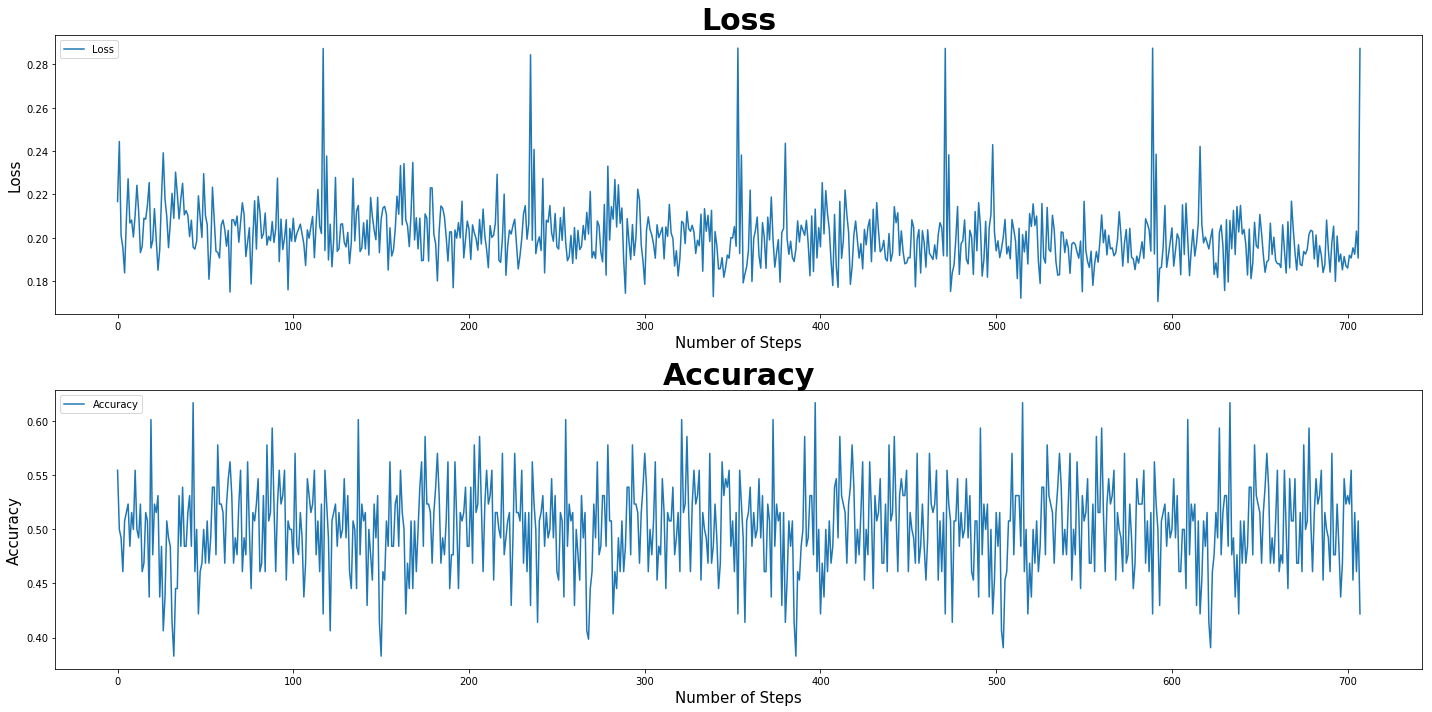

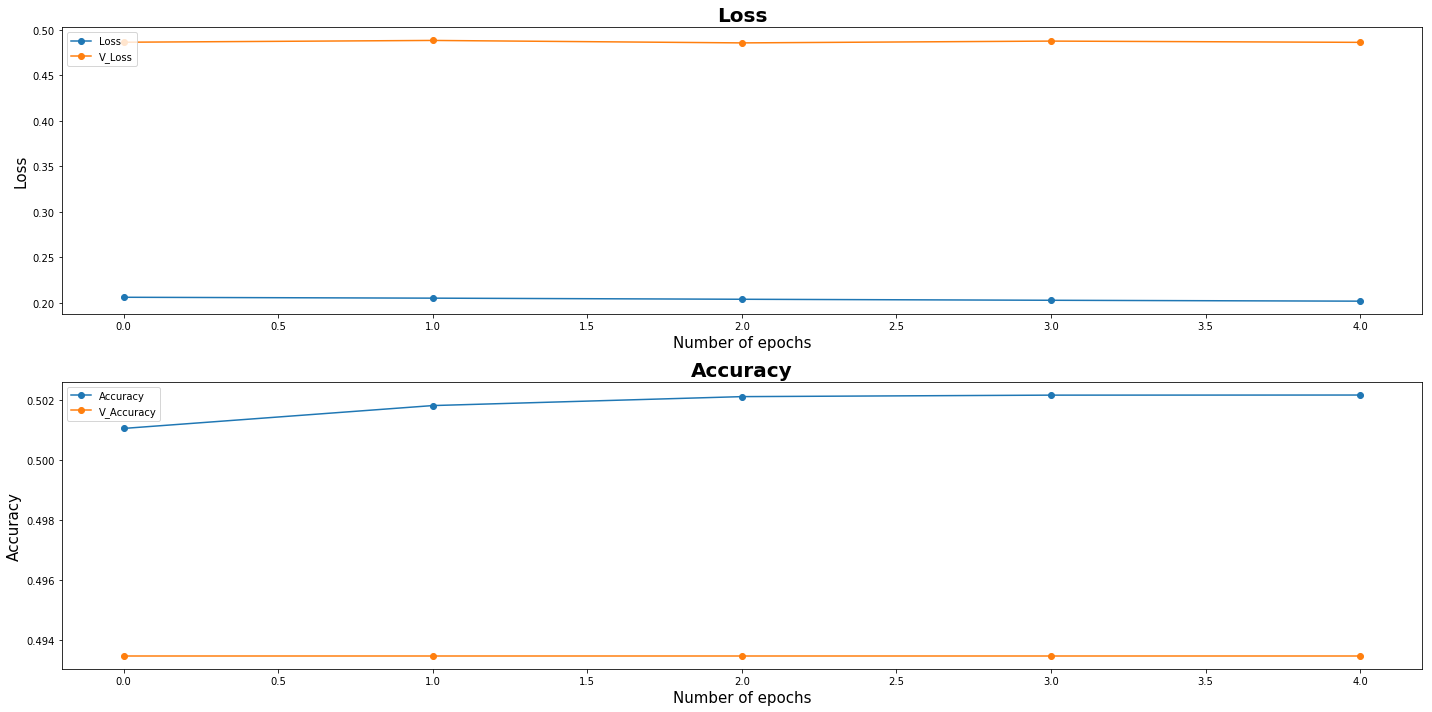

| Epoch [6] | Step [709] | lr [0.000200] | Loss: [0.1874] | Acc: [0.5625] | Time: 0.2s
| Epoch [6] | Step [710] | lr [0.000200] | Loss: [0.2387] | Acc: [0.5234] | Time: 0.2s
| Epoch [6] | Step [711] | lr [0.000200] | Loss: [0.1727] | Acc: [0.5078] | Time: 0.2s
| Epoch [6] | Step [712] | lr [0.000200] | Loss: [0.1796] | Acc: [0.4141] | Time: 0.2s
| Epoch [6] | Step [713] | lr [0.000200] | Loss: [0.1867] | Acc: [0.5078] | Time: 0.2s
| Epoch [6] | Step [714] | lr [0.000200] | Loss: [0.2009] | Acc: [0.5078] | Time: 0.2s
| Epoch [6] | Step [715] | lr [0.000200] | Loss: [0.2135] | Acc: [0.5156] | Time: 0.2s
| Epoch [6] | Step [716] | lr [0.000200] | Loss: [0.1816] | Acc: [0.5000] | Time: 0.2s
| Epoch [6] | Step [717] | lr [0.000200] | Loss: [0.1965] | Acc: [0.5078] | Time: 0.2s
| Epoch [6] | Step [718] | lr [0.000200] | Loss: [0.1940] | Acc: [0.4922] | Time: 0.2s
| Epoch [6] | Step [719] | lr [0.000200] | Loss: [0.2032] | Acc: [0.5000] | Time: 0.2s
| Epoch [6] | Step [720] | lr [0.000200] | 

| Epoch [6] | Step [805] | lr [0.000200] | Loss: [0.1795] | Acc: [0.4531] | Time: 0.1s
| Epoch [6] | Step [806] | lr [0.000200] | Loss: [0.1890] | Acc: [0.5156] | Time: 0.1s
| Epoch [6] | Step [807] | lr [0.000200] | Loss: [0.1972] | Acc: [0.5000] | Time: 0.1s
| Epoch [6] | Step [808] | lr [0.000200] | Loss: [0.1918] | Acc: [0.4922] | Time: 0.1s
| Epoch [6] | Step [809] | lr [0.000200] | Loss: [0.1879] | Acc: [0.4609] | Time: 0.1s
| Epoch [6] | Step [810] | lr [0.000200] | Loss: [0.1980] | Acc: [0.5703] | Time: 0.1s
| Epoch [6] | Step [811] | lr [0.000200] | Loss: [0.2094] | Acc: [0.4766] | Time: 0.1s
| Epoch [6] | Step [812] | lr [0.000200] | Loss: [0.1805] | Acc: [0.4766] | Time: 0.1s
| Epoch [6] | Step [813] | lr [0.000200] | Loss: [0.2028] | Acc: [0.5391] | Time: 0.1s
| Epoch [6] | Step [814] | lr [0.000200] | Loss: [0.1937] | Acc: [0.5078] | Time: 0.1s
| Epoch [6] | Step [815] | lr [0.000200] | Loss: [0.1975] | Acc: [0.4375] | Time: 0.1s
| Epoch [6] | Step [816] | lr [0.000200] | 

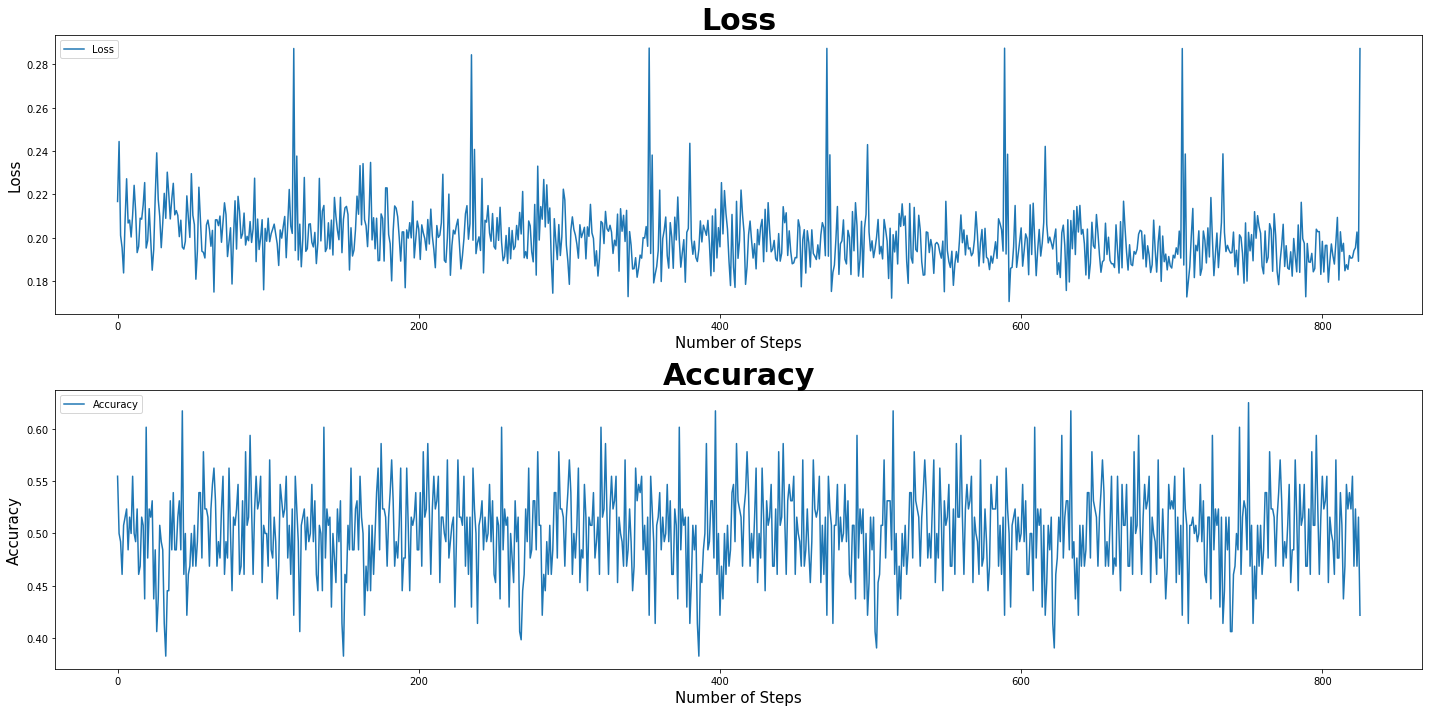

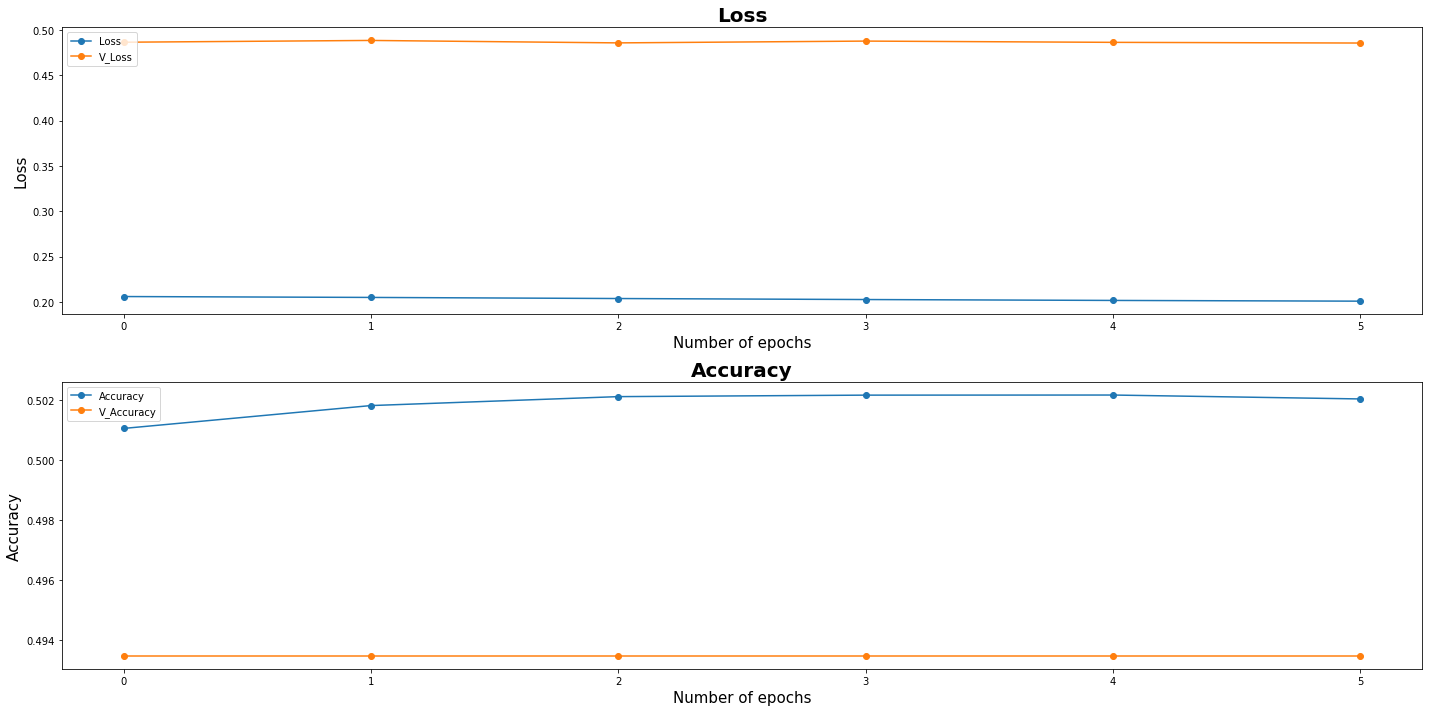

| Epoch [7] | Step [827] | lr [0.000200] | Loss: [0.1928] | Acc: [0.5703] | Time: 0.2s
| Epoch [7] | Step [828] | lr [0.000200] | Loss: [0.2388] | Acc: [0.5234] | Time: 0.2s
| Epoch [7] | Step [829] | lr [0.000200] | Loss: [0.1740] | Acc: [0.5000] | Time: 0.2s
| Epoch [7] | Step [830] | lr [0.000200] | Loss: [0.1694] | Acc: [0.4141] | Time: 0.2s
| Epoch [7] | Step [831] | lr [0.000200] | Loss: [0.1864] | Acc: [0.5078] | Time: 0.2s
| Epoch [7] | Step [832] | lr [0.000200] | Loss: [0.1985] | Acc: [0.5156] | Time: 0.2s
| Epoch [7] | Step [833] | lr [0.000200] | Loss: [0.2063] | Acc: [0.5391] | Time: 0.2s
| Epoch [7] | Step [834] | lr [0.000200] | Loss: [0.1831] | Acc: [0.4922] | Time: 0.2s
| Epoch [7] | Step [835] | lr [0.000200] | Loss: [0.1936] | Acc: [0.5156] | Time: 0.2s
| Epoch [7] | Step [836] | lr [0.000200] | Loss: [0.1982] | Acc: [0.4922] | Time: 0.2s
| Epoch [7] | Step [837] | lr [0.000200] | Loss: [0.2030] | Acc: [0.5000] | Time: 0.2s
| Epoch [7] | Step [838] | lr [0.000200] | 

| Epoch [7] | Step [923] | lr [0.000200] | Loss: [0.1793] | Acc: [0.4531] | Time: 0.1s
| Epoch [7] | Step [924] | lr [0.000200] | Loss: [0.1885] | Acc: [0.5156] | Time: 0.1s
| Epoch [7] | Step [925] | lr [0.000200] | Loss: [0.1951] | Acc: [0.5000] | Time: 0.1s
| Epoch [7] | Step [926] | lr [0.000200] | Loss: [0.1926] | Acc: [0.4922] | Time: 0.1s
| Epoch [7] | Step [927] | lr [0.000200] | Loss: [0.1838] | Acc: [0.4688] | Time: 0.1s
| Epoch [7] | Step [928] | lr [0.000200] | Loss: [0.2422] | Acc: [0.5703] | Time: 0.1s
| Epoch [7] | Step [929] | lr [0.000200] | Loss: [0.1964] | Acc: [0.4688] | Time: 0.1s
| Epoch [7] | Step [930] | lr [0.000200] | Loss: [0.1875] | Acc: [0.4766] | Time: 0.1s
| Epoch [7] | Step [931] | lr [0.000200] | Loss: [0.1972] | Acc: [0.5312] | Time: 0.1s
| Epoch [7] | Step [932] | lr [0.000200] | Loss: [0.1956] | Acc: [0.5000] | Time: 0.1s
| Epoch [7] | Step [933] | lr [0.000200] | Loss: [0.1911] | Acc: [0.4375] | Time: 0.1s
| Epoch [7] | Step [934] | lr [0.000200] | 

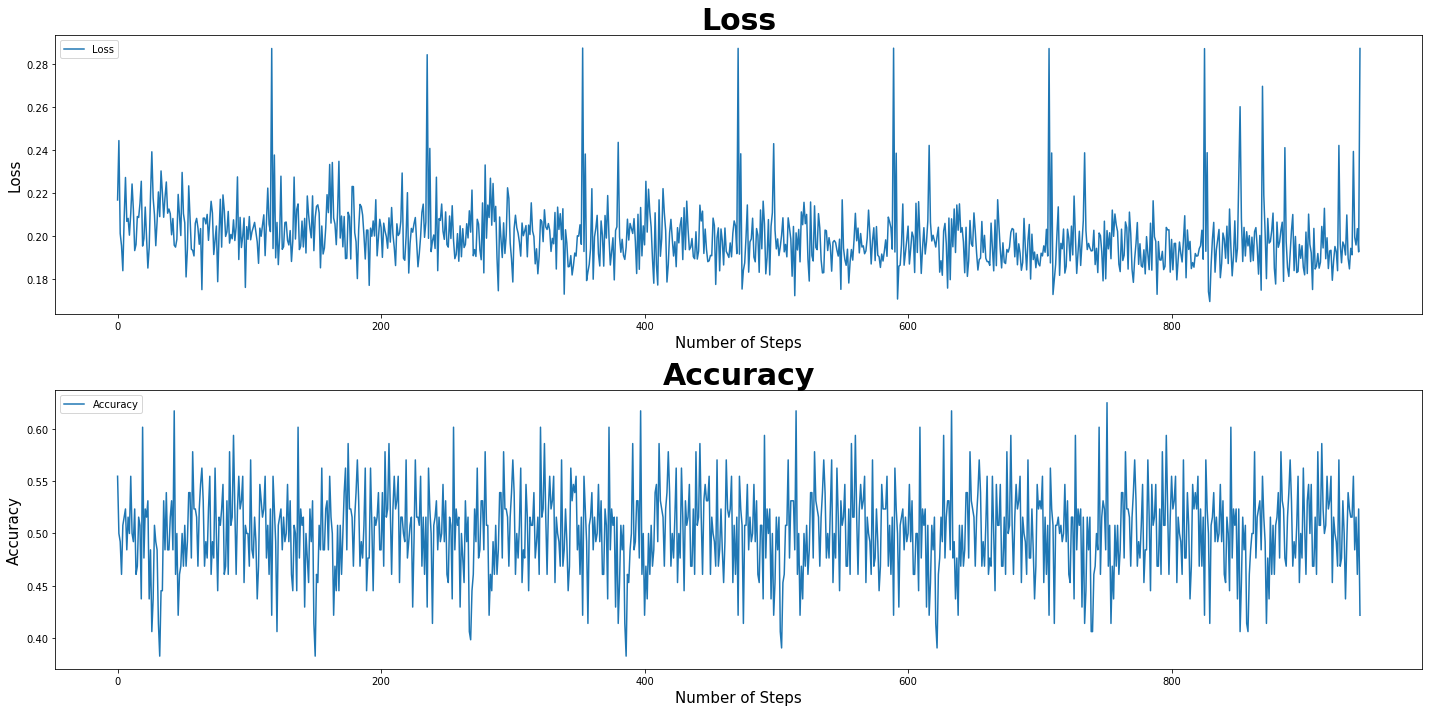

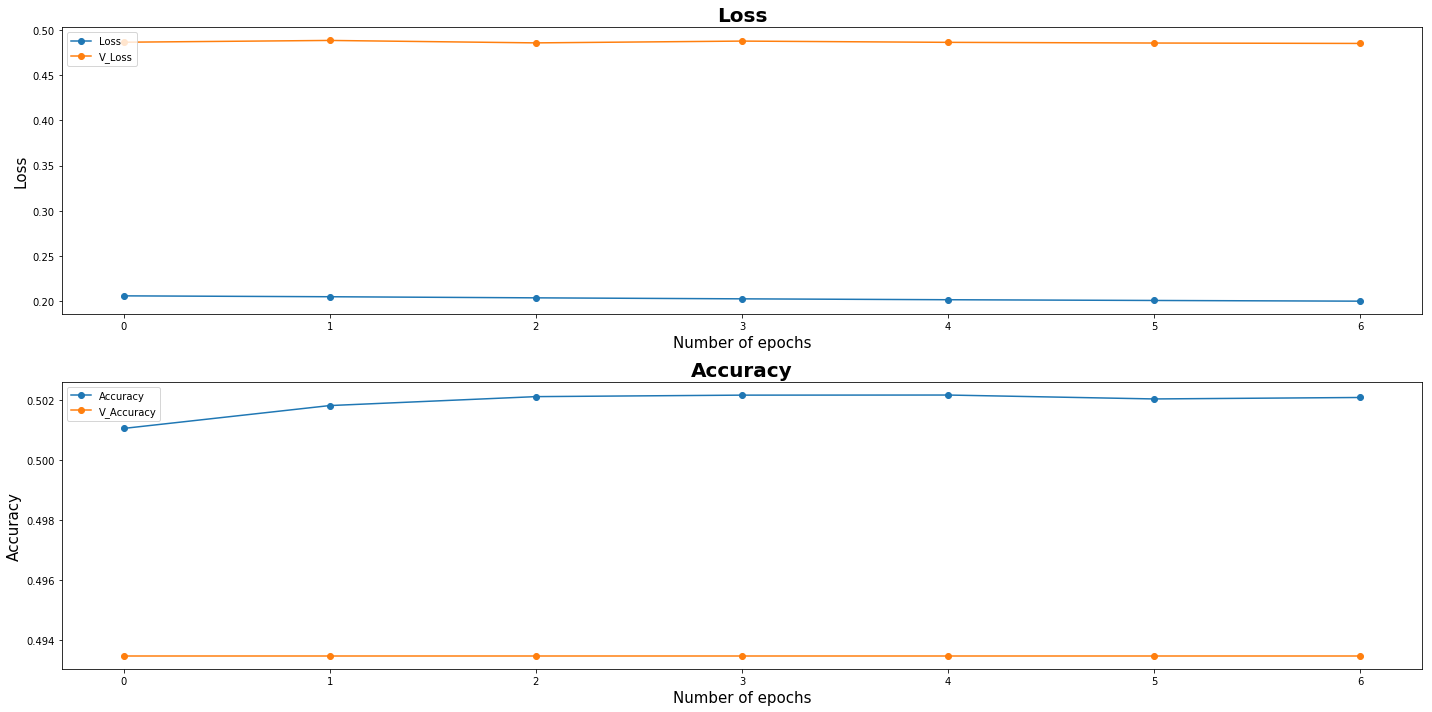

| Epoch [8] | Step [945] | lr [0.000200] | Loss: [0.1886] | Acc: [0.5547] | Time: 0.2s
| Epoch [8] | Step [946] | lr [0.000200] | Loss: [0.2448] | Acc: [0.5000] | Time: 0.2s
| Epoch [8] | Step [947] | lr [0.000200] | Loss: [0.1813] | Acc: [0.5000] | Time: 0.2s
| Epoch [8] | Step [948] | lr [0.000200] | Loss: [0.1750] | Acc: [0.4219] | Time: 0.2s
| Epoch [8] | Step [949] | lr [0.000200] | Loss: [0.2002] | Acc: [0.5078] | Time: 0.2s
| Epoch [8] | Step [950] | lr [0.000200] | Loss: [0.1982] | Acc: [0.5078] | Time: 0.2s
| Epoch [8] | Step [951] | lr [0.000200] | Loss: [0.1979] | Acc: [0.5312] | Time: 0.2s
| Epoch [8] | Step [952] | lr [0.000200] | Loss: [0.1829] | Acc: [0.4922] | Time: 0.2s
| Epoch [8] | Step [953] | lr [0.000200] | Loss: [0.1879] | Acc: [0.5312] | Time: 0.2s
| Epoch [8] | Step [954] | lr [0.000200] | Loss: [0.1934] | Acc: [0.4922] | Time: 0.2s
| Epoch [8] | Step [955] | lr [0.000200] | Loss: [0.1998] | Acc: [0.5000] | Time: 0.2s
| Epoch [8] | Step [956] | lr [0.000200] | 

| Epoch [8] | Step [1039] | lr [0.000200] | Loss: [0.1969] | Acc: [0.5312] | Time: 0.1s
| Epoch [8] | Step [1040] | lr [0.000200] | Loss: [0.1935] | Acc: [0.5547] | Time: 0.1s
| Epoch [8] | Step [1041] | lr [0.000200] | Loss: [0.1838] | Acc: [0.4531] | Time: 0.1s
| Epoch [8] | Step [1042] | lr [0.000200] | Loss: [0.1794] | Acc: [0.5234] | Time: 0.1s
| Epoch [8] | Step [1043] | lr [0.000200] | Loss: [0.2003] | Acc: [0.5000] | Time: 0.1s
| Epoch [8] | Step [1044] | lr [0.000200] | Loss: [0.1849] | Acc: [0.4922] | Time: 0.1s
| Epoch [8] | Step [1045] | lr [0.000200] | Loss: [0.1888] | Acc: [0.4688] | Time: 0.1s
| Epoch [8] | Step [1046] | lr [0.000200] | Loss: [0.2252] | Acc: [0.5703] | Time: 0.1s
| Epoch [8] | Step [1047] | lr [0.000200] | Loss: [0.1907] | Acc: [0.4688] | Time: 0.1s
| Epoch [8] | Step [1048] | lr [0.000200] | Loss: [0.1776] | Acc: [0.4766] | Time: 0.1s
| Epoch [8] | Step [1049] | lr [0.000200] | Loss: [0.2019] | Acc: [0.5312] | Time: 0.1s
| Epoch [8] | Step [1050] | lr [

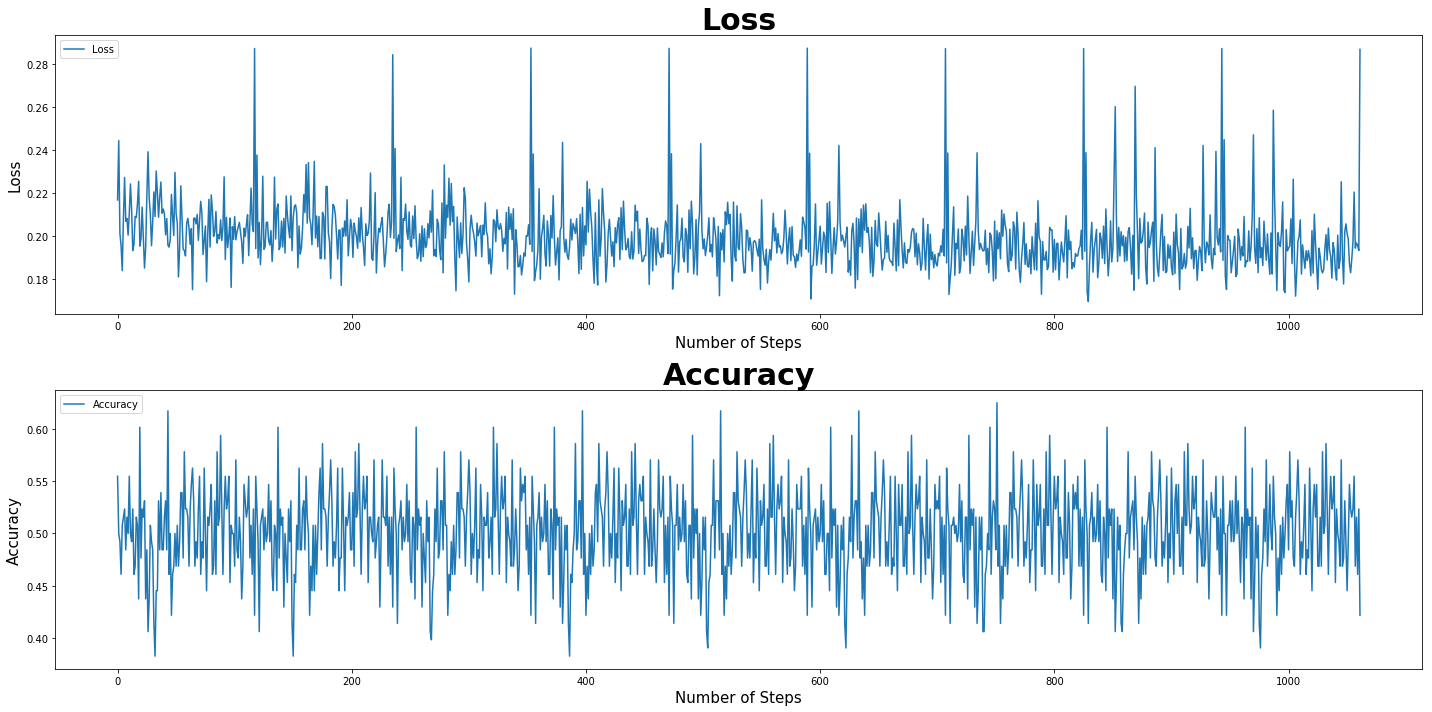

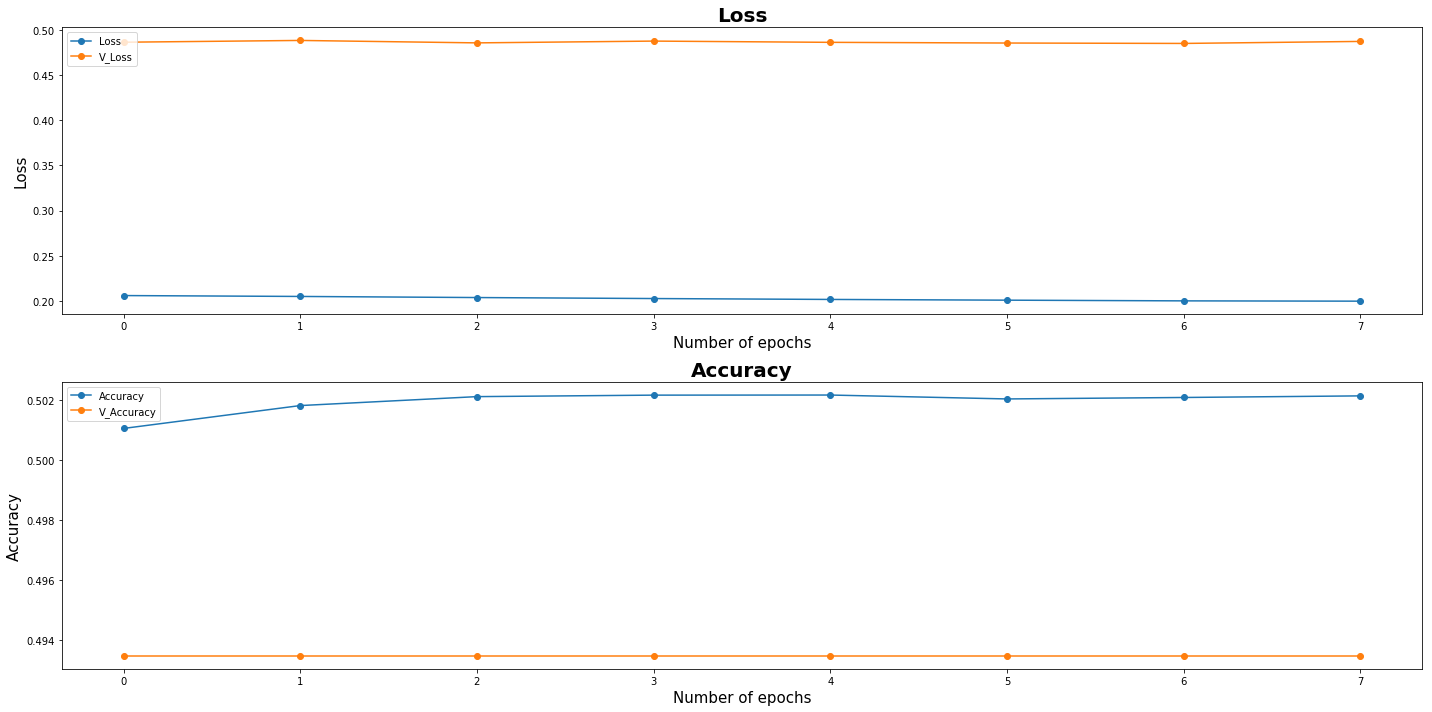

| Epoch [9] | Step [1063] | lr [0.000200] | Loss: [0.1816] | Acc: [0.5703] | Time: 0.2s
| Epoch [9] | Step [1064] | lr [0.000200] | Loss: [0.2433] | Acc: [0.5000] | Time: 0.2s
| Epoch [9] | Step [1065] | lr [0.000200] | Loss: [0.1803] | Acc: [0.5000] | Time: 0.2s
| Epoch [9] | Step [1066] | lr [0.000200] | Loss: [0.1746] | Acc: [0.4141] | Time: 0.2s
| Epoch [9] | Step [1067] | lr [0.000200] | Loss: [0.1924] | Acc: [0.5078] | Time: 0.2s
| Epoch [9] | Step [1068] | lr [0.000200] | Loss: [0.1965] | Acc: [0.5156] | Time: 0.2s
| Epoch [9] | Step [1069] | lr [0.000200] | Loss: [0.1998] | Acc: [0.5391] | Time: 0.2s
| Epoch [9] | Step [1070] | lr [0.000200] | Loss: [0.1818] | Acc: [0.4922] | Time: 0.2s
| Epoch [9] | Step [1071] | lr [0.000200] | Loss: [0.1913] | Acc: [0.5234] | Time: 0.2s
| Epoch [9] | Step [1072] | lr [0.000200] | Loss: [0.1953] | Acc: [0.4922] | Time: 0.2s
| Epoch [9] | Step [1073] | lr [0.000200] | Loss: [0.1965] | Acc: [0.5000] | Time: 0.2s
| Epoch [9] | Step [1074] | lr [

| Epoch [9] | Step [1157] | lr [0.000200] | Loss: [0.1921] | Acc: [0.5312] | Time: 0.1s
| Epoch [9] | Step [1158] | lr [0.000200] | Loss: [0.2018] | Acc: [0.5547] | Time: 0.1s
| Epoch [9] | Step [1159] | lr [0.000200] | Loss: [0.1726] | Acc: [0.4531] | Time: 0.1s
| Epoch [9] | Step [1160] | lr [0.000200] | Loss: [0.1849] | Acc: [0.5234] | Time: 0.1s
| Epoch [9] | Step [1161] | lr [0.000200] | Loss: [0.1981] | Acc: [0.5000] | Time: 0.1s
| Epoch [9] | Step [1162] | lr [0.000200] | Loss: [0.1802] | Acc: [0.4922] | Time: 0.1s
| Epoch [9] | Step [1163] | lr [0.000200] | Loss: [0.1808] | Acc: [0.4688] | Time: 0.1s
| Epoch [9] | Step [1164] | lr [0.000200] | Loss: [0.1962] | Acc: [0.5703] | Time: 0.1s
| Epoch [9] | Step [1165] | lr [0.000200] | Loss: [0.1859] | Acc: [0.4688] | Time: 0.1s
| Epoch [9] | Step [1166] | lr [0.000200] | Loss: [0.1801] | Acc: [0.4688] | Time: 0.1s
| Epoch [9] | Step [1167] | lr [0.000200] | Loss: [0.1884] | Acc: [0.5234] | Time: 0.1s
| Epoch [9] | Step [1168] | lr [

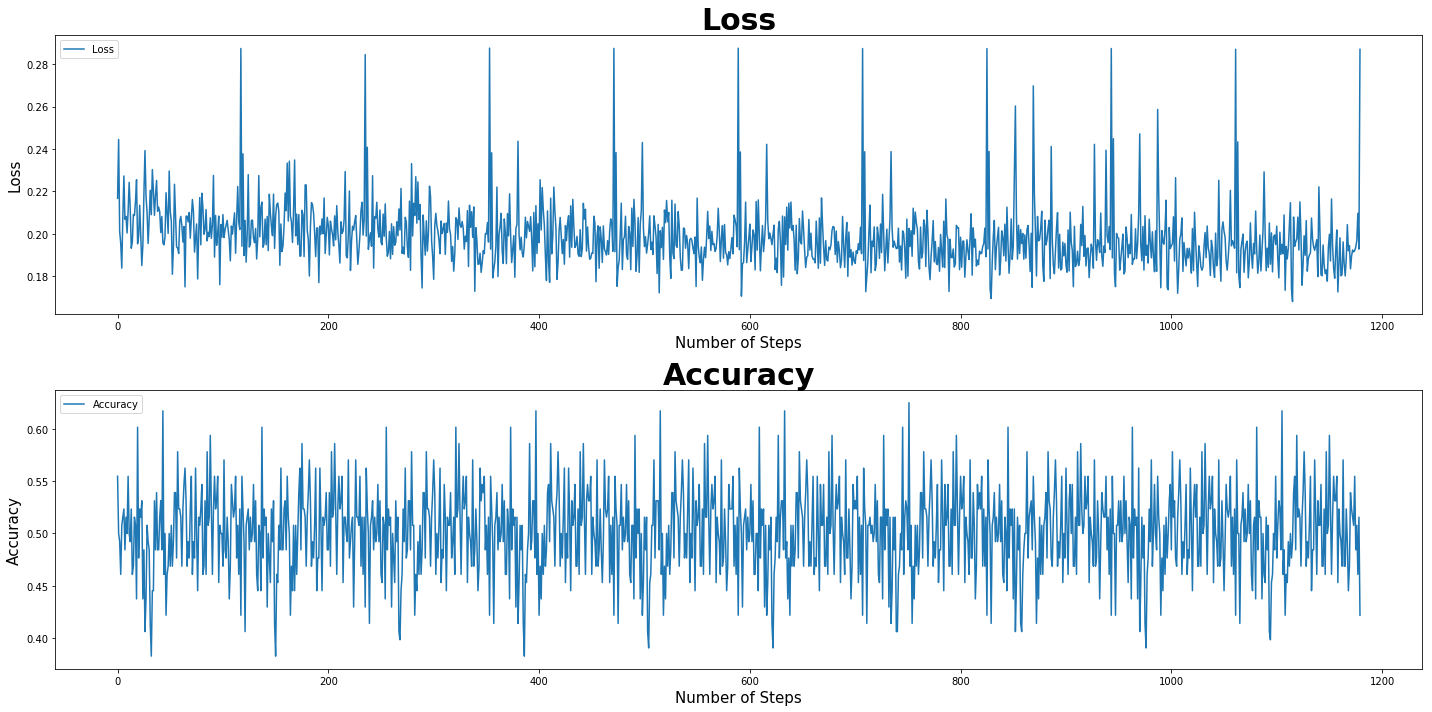

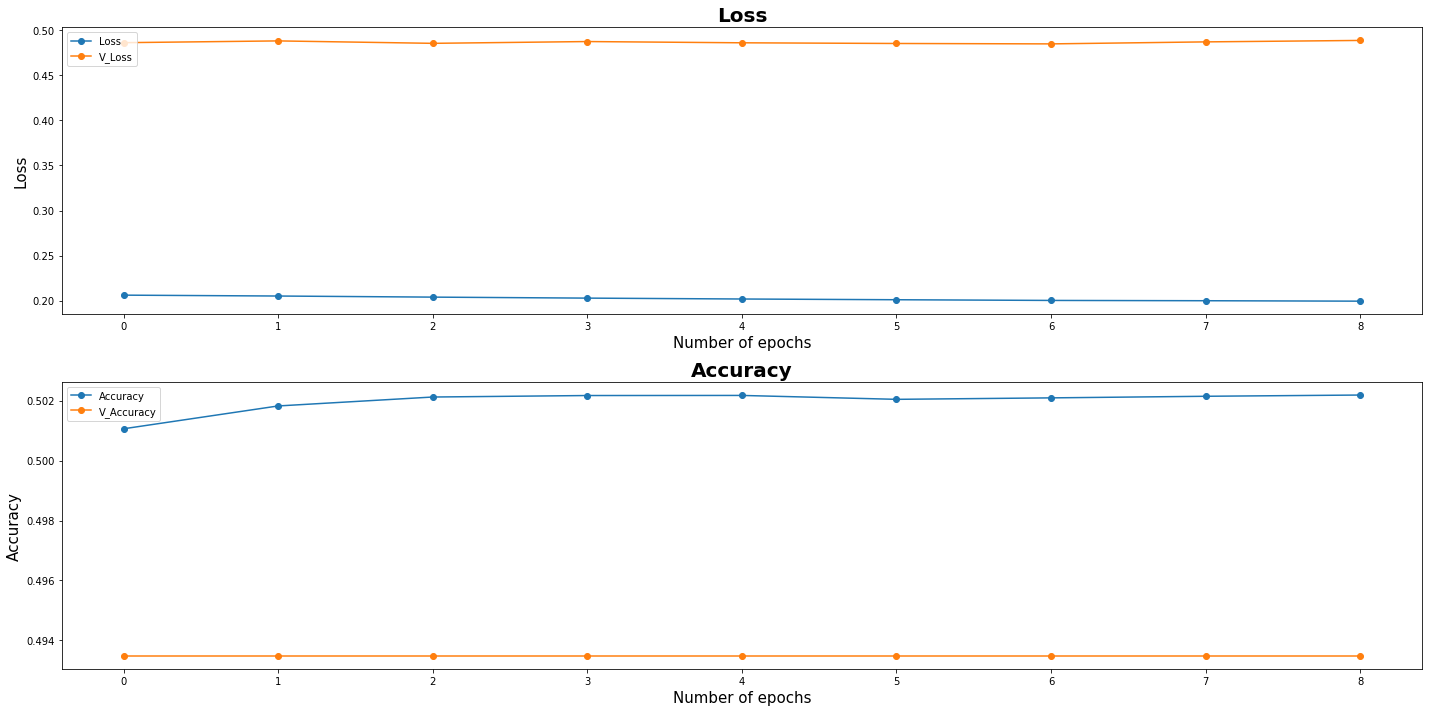

Model Saved
| Epoch [10] | Step [1181] | lr [0.000200] | Loss: [0.1867] | Acc: [0.5703] | Time: 0.2s
| Epoch [10] | Step [1182] | lr [0.000200] | Loss: [0.2379] | Acc: [0.5234] | Time: 0.2s
| Epoch [10] | Step [1183] | lr [0.000200] | Loss: [0.1786] | Acc: [0.4922] | Time: 0.2s
| Epoch [10] | Step [1184] | lr [0.000200] | Loss: [0.1752] | Acc: [0.4219] | Time: 0.2s
| Epoch [10] | Step [1185] | lr [0.000200] | Loss: [0.1941] | Acc: [0.4766] | Time: 0.2s
| Epoch [10] | Step [1186] | lr [0.000200] | Loss: [0.1899] | Acc: [0.5156] | Time: 0.2s
| Epoch [10] | Step [1187] | lr [0.000200] | Loss: [0.1956] | Acc: [0.5312] | Time: 0.2s
| Epoch [10] | Step [1188] | lr [0.000200] | Loss: [0.1875] | Acc: [0.4922] | Time: 0.2s
| Epoch [10] | Step [1189] | lr [0.000200] | Loss: [0.1857] | Acc: [0.5312] | Time: 0.2s
| Epoch [10] | Step [1190] | lr [0.000200] | Loss: [0.1893] | Acc: [0.4922] | Time: 0.2s
| Epoch [10] | Step [1191] | lr [0.000200] | Loss: [0.2004] | Acc: [0.5000] | Time: 0.2s
| Epoch [

| Epoch [10] | Step [1273] | lr [0.000200] | Loss: [0.1842] | Acc: [0.5547] | Time: 0.1s
| Epoch [10] | Step [1274] | lr [0.000200] | Loss: [0.1784] | Acc: [0.5234] | Time: 0.1s
| Epoch [10] | Step [1275] | lr [0.000200] | Loss: [0.1932] | Acc: [0.5312] | Time: 0.1s
| Epoch [10] | Step [1276] | lr [0.000200] | Loss: [0.1999] | Acc: [0.5625] | Time: 0.1s
| Epoch [10] | Step [1277] | lr [0.000200] | Loss: [0.1698] | Acc: [0.4531] | Time: 0.1s
| Epoch [10] | Step [1278] | lr [0.000200] | Loss: [0.1857] | Acc: [0.5234] | Time: 0.1s
| Epoch [10] | Step [1279] | lr [0.000200] | Loss: [0.1920] | Acc: [0.5000] | Time: 0.1s
| Epoch [10] | Step [1280] | lr [0.000200] | Loss: [0.1795] | Acc: [0.4922] | Time: 0.1s
| Epoch [10] | Step [1281] | lr [0.000200] | Loss: [0.1893] | Acc: [0.4688] | Time: 0.1s
| Epoch [10] | Step [1282] | lr [0.000200] | Loss: [0.1962] | Acc: [0.5703] | Time: 0.1s
| Epoch [10] | Step [1283] | lr [0.000200] | Loss: [0.1920] | Acc: [0.4688] | Time: 0.1s
| Epoch [10] | Step [

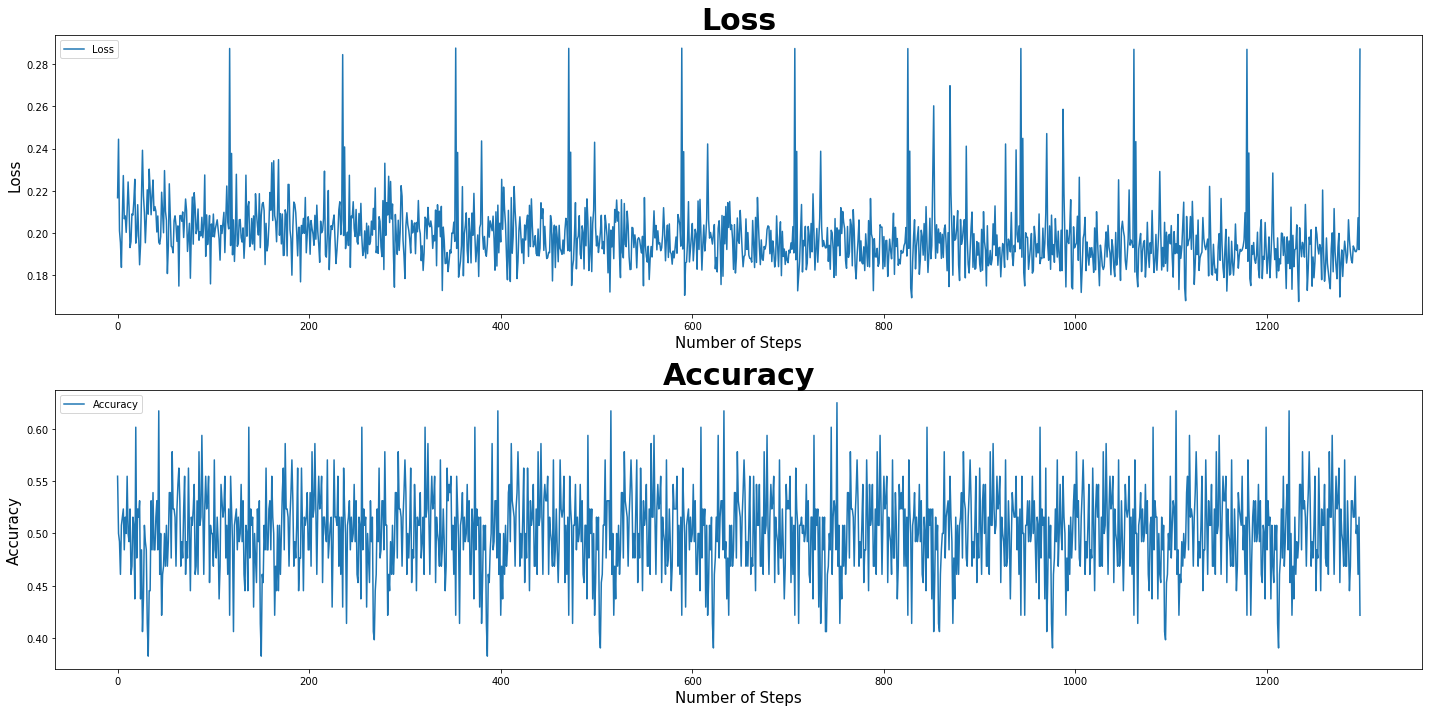

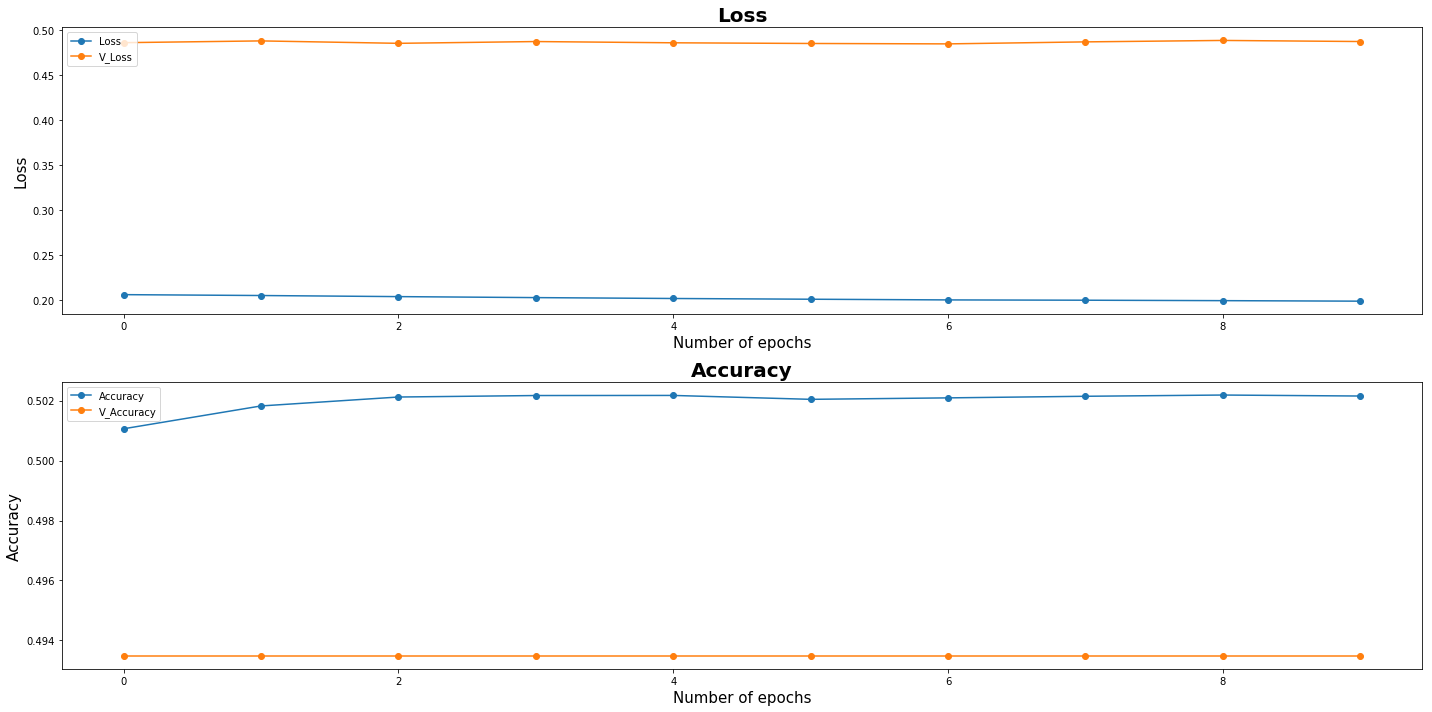

| Epoch [11] | Step [1299] | lr [0.000200] | Loss: [0.1899] | Acc: [0.5625] | Time: 0.2s
| Epoch [11] | Step [1300] | lr [0.000200] | Loss: [0.2381] | Acc: [0.5234] | Time: 0.2s
| Epoch [11] | Step [1301] | lr [0.000200] | Loss: [0.1778] | Acc: [0.4922] | Time: 0.2s
| Epoch [11] | Step [1302] | lr [0.000200] | Loss: [0.1697] | Acc: [0.4375] | Time: 0.2s
| Epoch [11] | Step [1303] | lr [0.000200] | Loss: [0.1919] | Acc: [0.5078] | Time: 0.2s
| Epoch [11] | Step [1304] | lr [0.000200] | Loss: [0.1896] | Acc: [0.5156] | Time: 0.2s
| Epoch [11] | Step [1305] | lr [0.000200] | Loss: [0.2041] | Acc: [0.5312] | Time: 0.2s
| Epoch [11] | Step [1306] | lr [0.000200] | Loss: [0.1940] | Acc: [0.4922] | Time: 0.2s
| Epoch [11] | Step [1307] | lr [0.000200] | Loss: [0.1856] | Acc: [0.5312] | Time: 0.2s
| Epoch [11] | Step [1308] | lr [0.000200] | Loss: [0.1940] | Acc: [0.4922] | Time: 0.2s
| Epoch [11] | Step [1309] | lr [0.000200] | Loss: [0.2071] | Acc: [0.5000] | Time: 0.2s
| Epoch [11] | Step [

| Epoch [11] | Step [1393] | lr [0.000200] | Loss: [0.2012] | Acc: [0.5312] | Time: 0.1s
| Epoch [11] | Step [1394] | lr [0.000200] | Loss: [0.1972] | Acc: [0.5625] | Time: 0.1s
| Epoch [11] | Step [1395] | lr [0.000200] | Loss: [0.1705] | Acc: [0.4531] | Time: 0.1s
| Epoch [11] | Step [1396] | lr [0.000200] | Loss: [0.1859] | Acc: [0.5234] | Time: 0.1s
| Epoch [11] | Step [1397] | lr [0.000200] | Loss: [0.1932] | Acc: [0.5000] | Time: 0.1s
| Epoch [11] | Step [1398] | lr [0.000200] | Loss: [0.1833] | Acc: [0.4922] | Time: 0.1s
| Epoch [11] | Step [1399] | lr [0.000200] | Loss: [0.1790] | Acc: [0.4688] | Time: 0.1s
| Epoch [11] | Step [1400] | lr [0.000200] | Loss: [0.1964] | Acc: [0.5703] | Time: 0.1s
| Epoch [11] | Step [1401] | lr [0.000200] | Loss: [0.1927] | Acc: [0.4688] | Time: 0.1s
| Epoch [11] | Step [1402] | lr [0.000200] | Loss: [0.1772] | Acc: [0.4688] | Time: 0.1s
| Epoch [11] | Step [1403] | lr [0.000200] | Loss: [0.1906] | Acc: [0.5312] | Time: 0.1s
| Epoch [11] | Step [

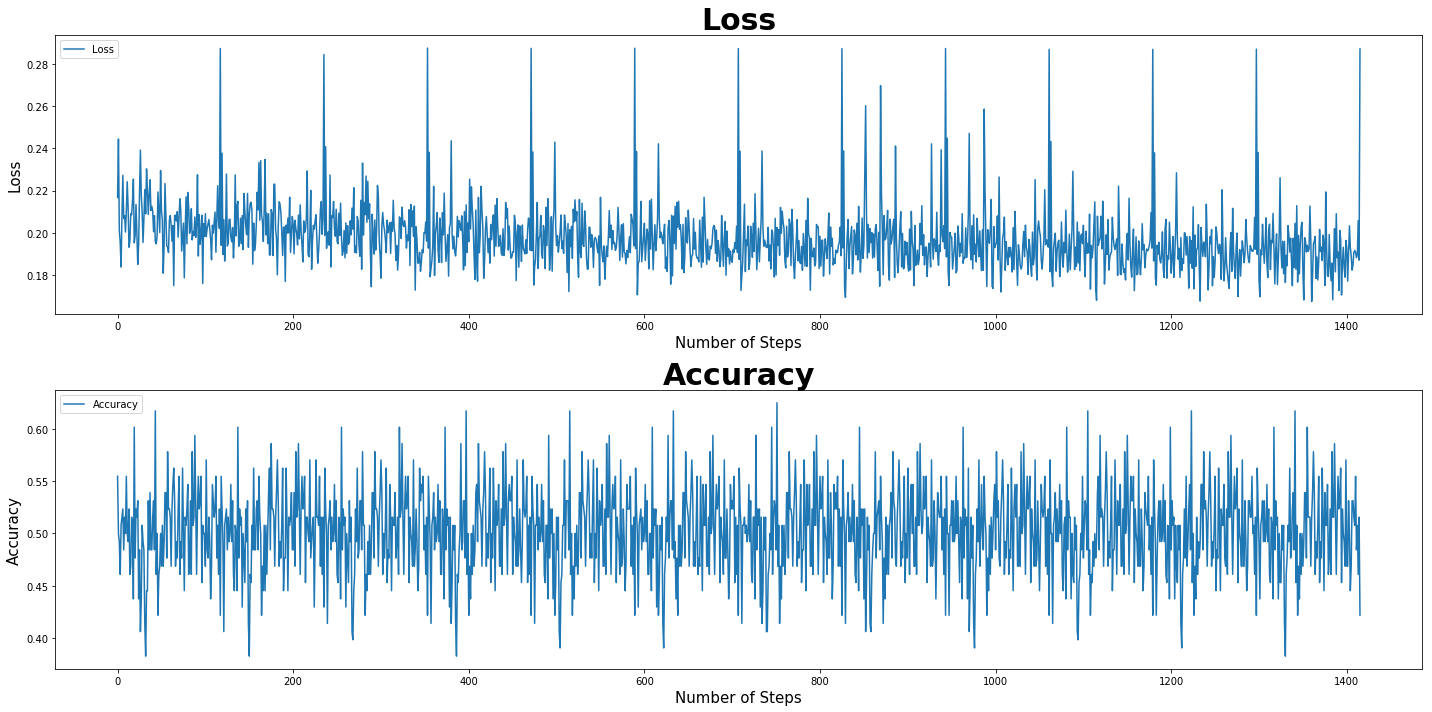

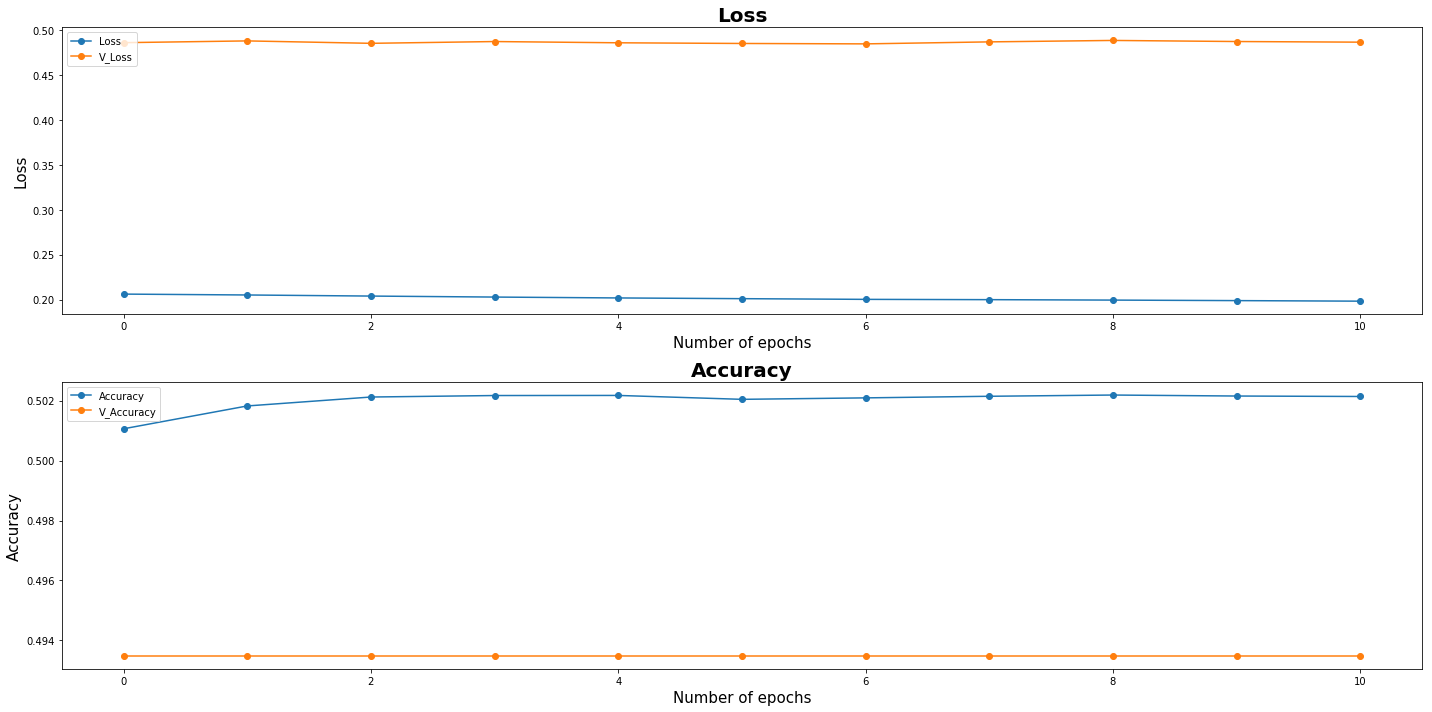

| Epoch [12] | Step [1417] | lr [0.000200] | Loss: [0.1905] | Acc: [0.5703] | Time: 0.2s
| Epoch [12] | Step [1418] | lr [0.000200] | Loss: [0.2384] | Acc: [0.5234] | Time: 0.2s
| Epoch [12] | Step [1419] | lr [0.000200] | Loss: [0.1776] | Acc: [0.4922] | Time: 0.2s
| Epoch [12] | Step [1420] | lr [0.000200] | Loss: [0.1709] | Acc: [0.4375] | Time: 0.2s
| Epoch [12] | Step [1421] | lr [0.000200] | Loss: [0.1904] | Acc: [0.5078] | Time: 0.2s
| Epoch [12] | Step [1422] | lr [0.000200] | Loss: [0.1878] | Acc: [0.5156] | Time: 0.2s
| Epoch [12] | Step [1423] | lr [0.000200] | Loss: [0.2012] | Acc: [0.5391] | Time: 0.2s
| Epoch [12] | Step [1424] | lr [0.000200] | Loss: [0.1973] | Acc: [0.4922] | Time: 0.2s
| Epoch [12] | Step [1425] | lr [0.000200] | Loss: [0.1812] | Acc: [0.5312] | Time: 0.2s
| Epoch [12] | Step [1426] | lr [0.000200] | Loss: [0.1978] | Acc: [0.4922] | Time: 0.2s
| Epoch [12] | Step [1427] | lr [0.000200] | Loss: [0.2030] | Acc: [0.5000] | Time: 0.2s
| Epoch [12] | Step [

| Epoch [12] | Step [1511] | lr [0.000200] | Loss: [0.1951] | Acc: [0.5312] | Time: 0.1s
| Epoch [12] | Step [1512] | lr [0.000200] | Loss: [0.2008] | Acc: [0.5625] | Time: 0.1s
| Epoch [12] | Step [1513] | lr [0.000200] | Loss: [0.1652] | Acc: [0.4531] | Time: 0.1s
| Epoch [12] | Step [1514] | lr [0.000200] | Loss: [0.1857] | Acc: [0.5156] | Time: 0.1s
| Epoch [12] | Step [1515] | lr [0.000200] | Loss: [0.1892] | Acc: [0.5000] | Time: 0.1s
| Epoch [12] | Step [1516] | lr [0.000200] | Loss: [0.1844] | Acc: [0.4922] | Time: 0.1s
| Epoch [12] | Step [1517] | lr [0.000200] | Loss: [0.1798] | Acc: [0.4688] | Time: 0.1s
| Epoch [12] | Step [1518] | lr [0.000200] | Loss: [0.1965] | Acc: [0.5703] | Time: 0.1s
| Epoch [12] | Step [1519] | lr [0.000200] | Loss: [0.1811] | Acc: [0.4688] | Time: 0.1s
| Epoch [12] | Step [1520] | lr [0.000200] | Loss: [0.1785] | Acc: [0.4688] | Time: 0.1s
| Epoch [12] | Step [1521] | lr [0.000200] | Loss: [0.1898] | Acc: [0.5312] | Time: 0.1s
| Epoch [12] | Step [

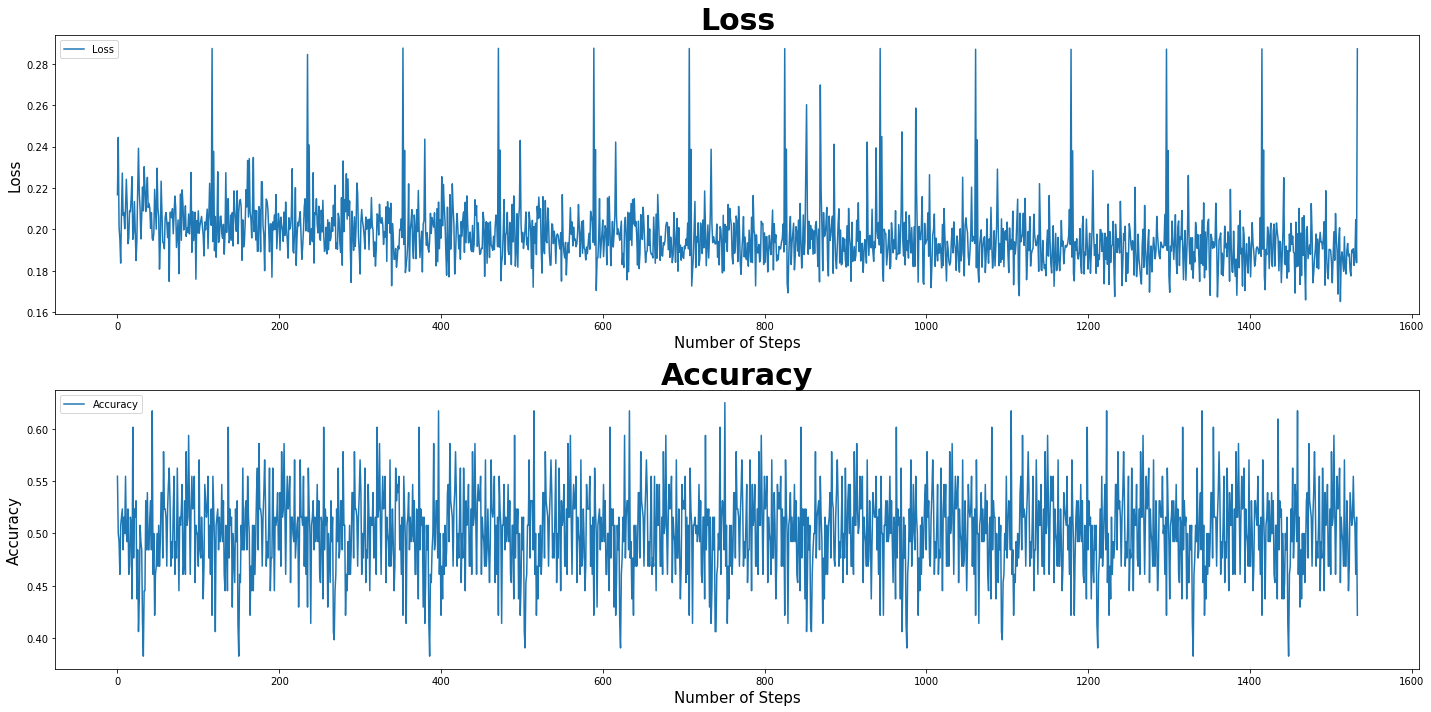

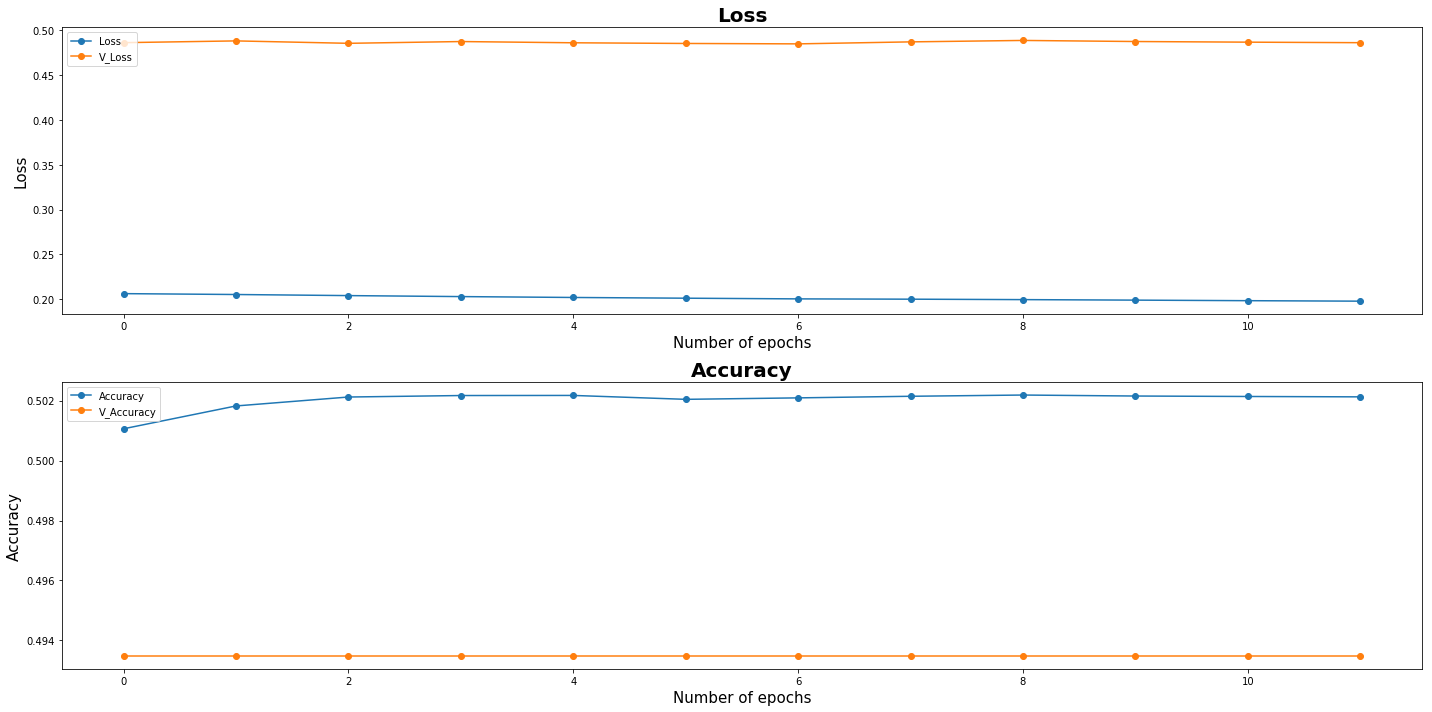

| Epoch [13] | Step [1535] | lr [0.000200] | Loss: [0.1833] | Acc: [0.5703] | Time: 0.2s
| Epoch [13] | Step [1536] | lr [0.000200] | Loss: [0.2385] | Acc: [0.5234] | Time: 0.2s
| Epoch [13] | Step [1537] | lr [0.000200] | Loss: [0.1770] | Acc: [0.4922] | Time: 0.2s
| Epoch [13] | Step [1538] | lr [0.000200] | Loss: [0.1695] | Acc: [0.4375] | Time: 0.2s
| Epoch [13] | Step [1539] | lr [0.000200] | Loss: [0.1896] | Acc: [0.5078] | Time: 0.2s
| Epoch [13] | Step [1540] | lr [0.000200] | Loss: [0.1845] | Acc: [0.5156] | Time: 0.2s
| Epoch [13] | Step [1541] | lr [0.000200] | Loss: [0.1998] | Acc: [0.5469] | Time: 0.2s
| Epoch [13] | Step [1542] | lr [0.000200] | Loss: [0.1978] | Acc: [0.4922] | Time: 0.2s
| Epoch [13] | Step [1543] | lr [0.000200] | Loss: [0.1785] | Acc: [0.5312] | Time: 0.2s
| Epoch [13] | Step [1544] | lr [0.000200] | Loss: [0.1942] | Acc: [0.4922] | Time: 0.2s
| Epoch [13] | Step [1545] | lr [0.000200] | Loss: [0.2026] | Acc: [0.5000] | Time: 0.2s
| Epoch [13] | Step [

| Epoch [13] | Step [1629] | lr [0.000200] | Loss: [0.1958] | Acc: [0.5234] | Time: 0.1s
| Epoch [13] | Step [1630] | lr [0.000200] | Loss: [0.2018] | Acc: [0.5547] | Time: 0.1s
| Epoch [13] | Step [1631] | lr [0.000200] | Loss: [0.1721] | Acc: [0.4531] | Time: 0.1s
| Epoch [13] | Step [1632] | lr [0.000200] | Loss: [0.1861] | Acc: [0.5156] | Time: 0.1s
| Epoch [13] | Step [1633] | lr [0.000200] | Loss: [0.1952] | Acc: [0.5000] | Time: 0.1s
| Epoch [13] | Step [1634] | lr [0.000200] | Loss: [0.1845] | Acc: [0.4922] | Time: 0.1s
| Epoch [13] | Step [1635] | lr [0.000200] | Loss: [0.1763] | Acc: [0.4688] | Time: 0.1s
| Epoch [13] | Step [1636] | lr [0.000200] | Loss: [0.1967] | Acc: [0.5703] | Time: 0.1s
| Epoch [13] | Step [1637] | lr [0.000200] | Loss: [0.1834] | Acc: [0.4688] | Time: 0.1s
| Epoch [13] | Step [1638] | lr [0.000200] | Loss: [0.1725] | Acc: [0.4766] | Time: 0.1s
| Epoch [13] | Step [1639] | lr [0.000200] | Loss: [0.1894] | Acc: [0.5391] | Time: 0.1s
| Epoch [13] | Step [

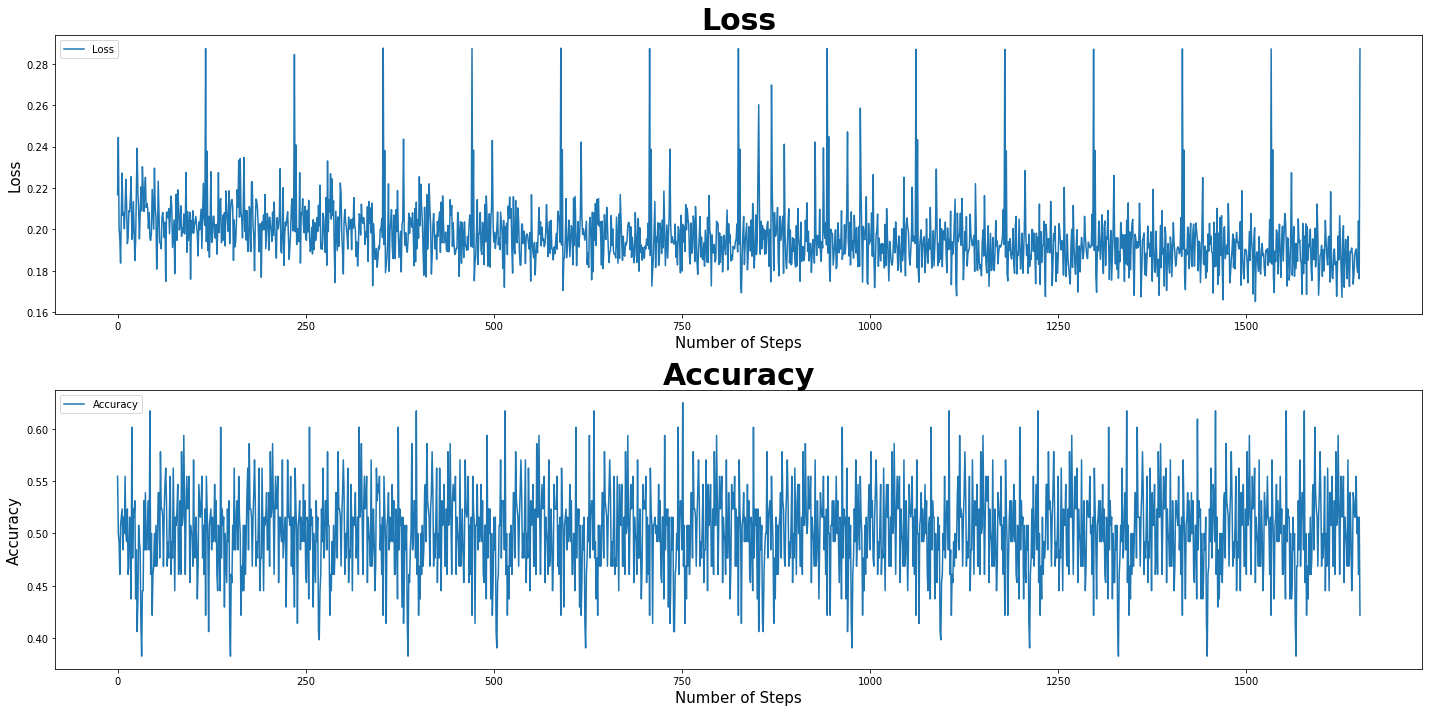

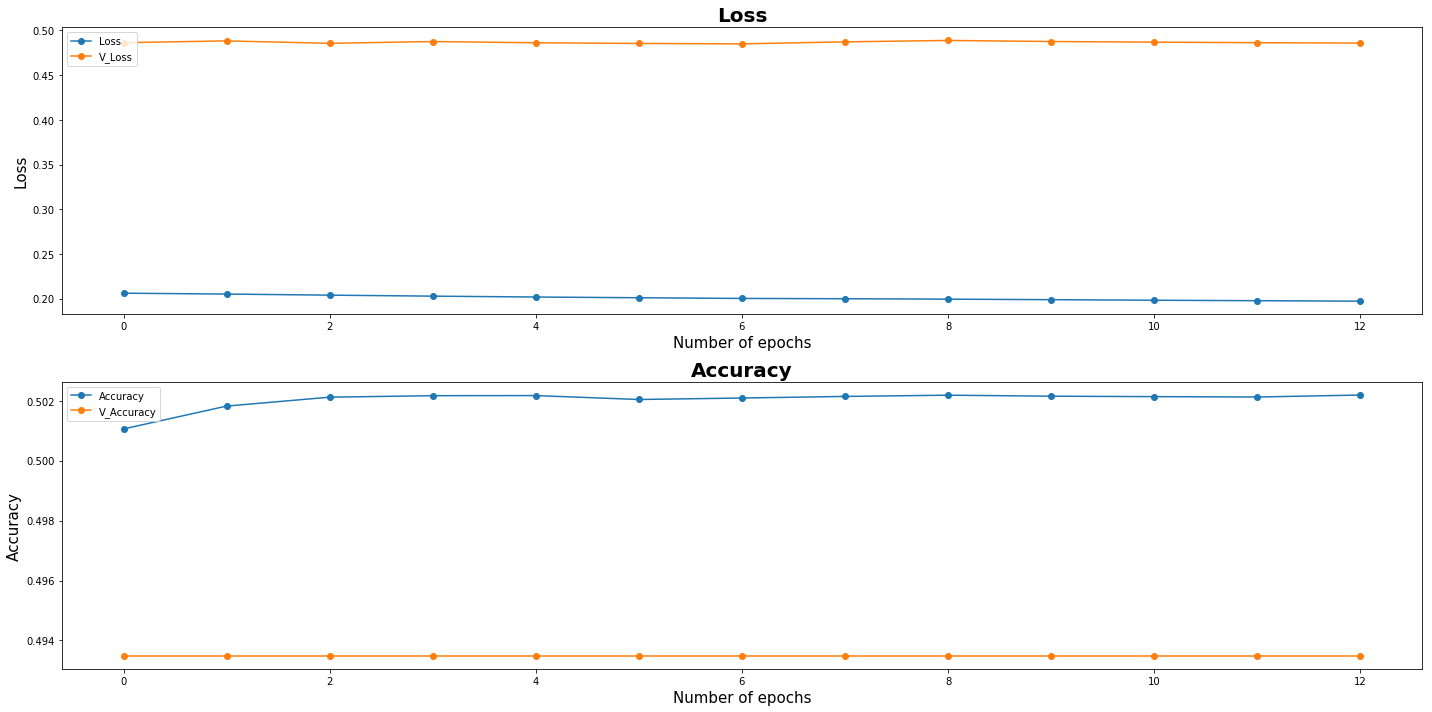

| Epoch [14] | Step [1653] | lr [0.000200] | Loss: [0.1825] | Acc: [0.5625] | Time: 0.2s
| Epoch [14] | Step [1654] | lr [0.000200] | Loss: [0.2386] | Acc: [0.5234] | Time: 0.2s
| Epoch [14] | Step [1655] | lr [0.000200] | Loss: [0.1765] | Acc: [0.5000] | Time: 0.2s
| Epoch [14] | Step [1656] | lr [0.000200] | Loss: [0.1655] | Acc: [0.4297] | Time: 0.2s
| Epoch [14] | Step [1657] | lr [0.000200] | Loss: [0.1891] | Acc: [0.5078] | Time: 0.2s
| Epoch [14] | Step [1658] | lr [0.000200] | Loss: [0.1840] | Acc: [0.5156] | Time: 0.2s
| Epoch [14] | Step [1659] | lr [0.000200] | Loss: [0.1990] | Acc: [0.5469] | Time: 0.2s
| Epoch [14] | Step [1660] | lr [0.000200] | Loss: [0.1972] | Acc: [0.4922] | Time: 0.2s
| Epoch [14] | Step [1661] | lr [0.000200] | Loss: [0.1793] | Acc: [0.5312] | Time: 0.2s
| Epoch [14] | Step [1662] | lr [0.000200] | Loss: [0.1946] | Acc: [0.4922] | Time: 0.2s
| Epoch [14] | Step [1663] | lr [0.000200] | Loss: [0.2094] | Acc: [0.4922] | Time: 0.2s
| Epoch [14] | Step [

| Epoch [14] | Step [1747] | lr [0.000200] | Loss: [0.1946] | Acc: [0.5234] | Time: 0.1s
| Epoch [14] | Step [1748] | lr [0.000200] | Loss: [0.2040] | Acc: [0.5625] | Time: 0.1s
| Epoch [14] | Step [1749] | lr [0.000200] | Loss: [0.1744] | Acc: [0.4609] | Time: 0.1s
| Epoch [14] | Step [1750] | lr [0.000200] | Loss: [0.1818] | Acc: [0.5156] | Time: 0.1s
| Epoch [14] | Step [1751] | lr [0.000200] | Loss: [0.1968] | Acc: [0.5000] | Time: 0.1s
| Epoch [14] | Step [1752] | lr [0.000200] | Loss: [0.1830] | Acc: [0.4922] | Time: 0.1s
| Epoch [14] | Step [1753] | lr [0.000200] | Loss: [0.1773] | Acc: [0.4688] | Time: 0.1s
| Epoch [14] | Step [1754] | lr [0.000200] | Loss: [0.1969] | Acc: [0.5703] | Time: 0.1s
| Epoch [14] | Step [1755] | lr [0.000200] | Loss: [0.1858] | Acc: [0.4688] | Time: 0.1s
| Epoch [14] | Step [1756] | lr [0.000200] | Loss: [0.1763] | Acc: [0.4766] | Time: 0.1s
| Epoch [14] | Step [1757] | lr [0.000200] | Loss: [0.1824] | Acc: [0.5312] | Time: 0.1s
| Epoch [14] | Step [

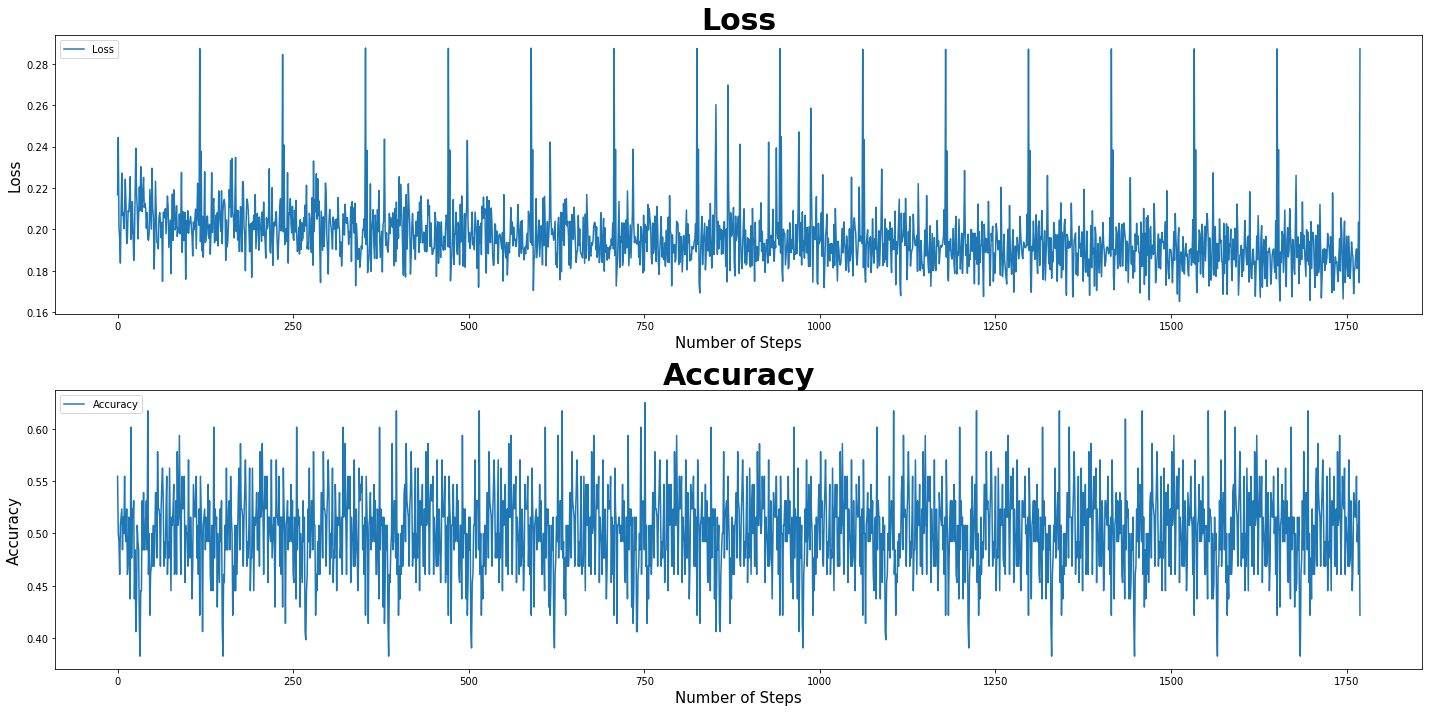

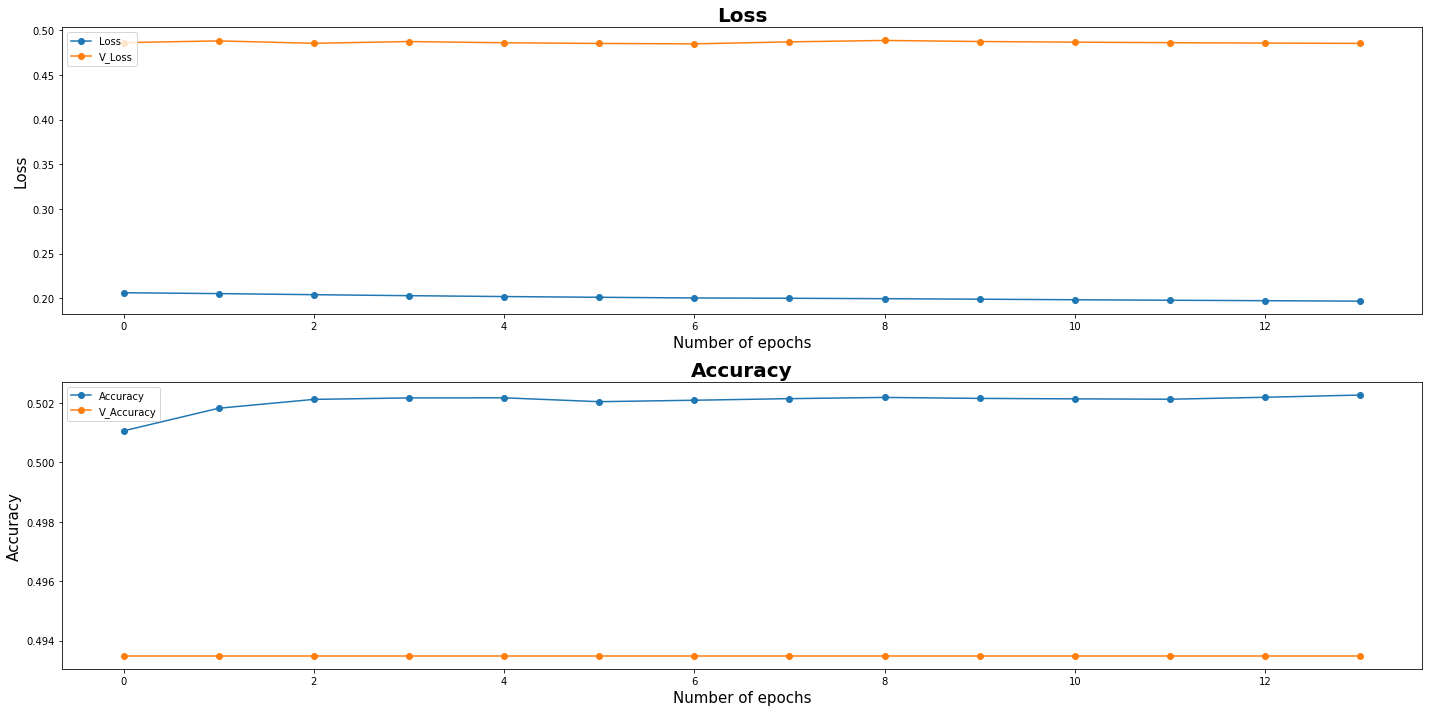

| Epoch [15] | Step [1771] | lr [0.000200] | Loss: [0.1796] | Acc: [0.5625] | Time: 0.2s
| Epoch [15] | Step [1772] | lr [0.000200] | Loss: [0.2387] | Acc: [0.5234] | Time: 0.2s
| Epoch [15] | Step [1773] | lr [0.000200] | Loss: [0.1827] | Acc: [0.5000] | Time: 0.2s
| Epoch [15] | Step [1774] | lr [0.000200] | Loss: [0.1719] | Acc: [0.4219] | Time: 0.2s
| Epoch [15] | Step [1775] | lr [0.000200] | Loss: [0.1885] | Acc: [0.5078] | Time: 0.2s
| Epoch [15] | Step [1776] | lr [0.000200] | Loss: [0.1824] | Acc: [0.5156] | Time: 0.2s
| Epoch [15] | Step [1777] | lr [0.000200] | Loss: [0.1956] | Acc: [0.5391] | Time: 0.2s
| Epoch [15] | Step [1778] | lr [0.000200] | Loss: [0.1980] | Acc: [0.4922] | Time: 0.2s
| Epoch [15] | Step [1779] | lr [0.000200] | Loss: [0.1719] | Acc: [0.5312] | Time: 0.2s
| Epoch [15] | Step [1780] | lr [0.000200] | Loss: [0.1879] | Acc: [0.4922] | Time: 0.2s
| Epoch [15] | Step [1781] | lr [0.000200] | Loss: [0.2065] | Acc: [0.5000] | Time: 0.2s
| Epoch [15] | Step [

| Epoch [15] | Step [1865] | lr [0.000200] | Loss: [0.1998] | Acc: [0.5234] | Time: 0.1s
| Epoch [15] | Step [1866] | lr [0.000200] | Loss: [0.1924] | Acc: [0.5625] | Time: 0.1s
| Epoch [15] | Step [1867] | lr [0.000200] | Loss: [0.1702] | Acc: [0.4531] | Time: 0.1s
| Epoch [15] | Step [1868] | lr [0.000200] | Loss: [0.1837] | Acc: [0.5234] | Time: 0.1s
| Epoch [15] | Step [1869] | lr [0.000200] | Loss: [0.1989] | Acc: [0.5078] | Time: 0.1s
| Epoch [15] | Step [1870] | lr [0.000200] | Loss: [0.1815] | Acc: [0.4922] | Time: 0.1s
| Epoch [15] | Step [1871] | lr [0.000200] | Loss: [0.1790] | Acc: [0.4688] | Time: 0.1s
| Epoch [15] | Step [1872] | lr [0.000200] | Loss: [0.1970] | Acc: [0.5703] | Time: 0.1s
| Epoch [15] | Step [1873] | lr [0.000200] | Loss: [0.1911] | Acc: [0.4688] | Time: 0.1s
| Epoch [15] | Step [1874] | lr [0.000200] | Loss: [0.1738] | Acc: [0.4844] | Time: 0.1s
| Epoch [15] | Step [1875] | lr [0.000200] | Loss: [0.1862] | Acc: [0.5234] | Time: 0.1s
| Epoch [15] | Step [

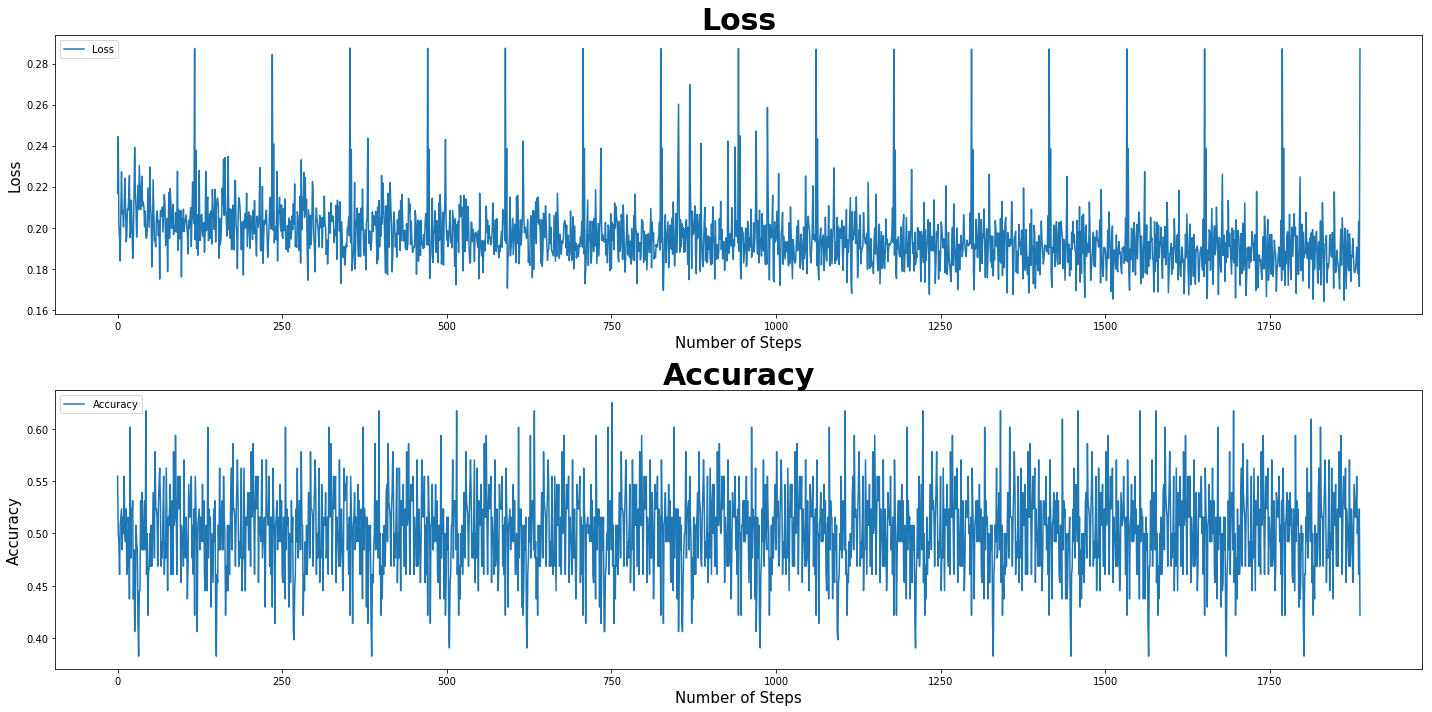

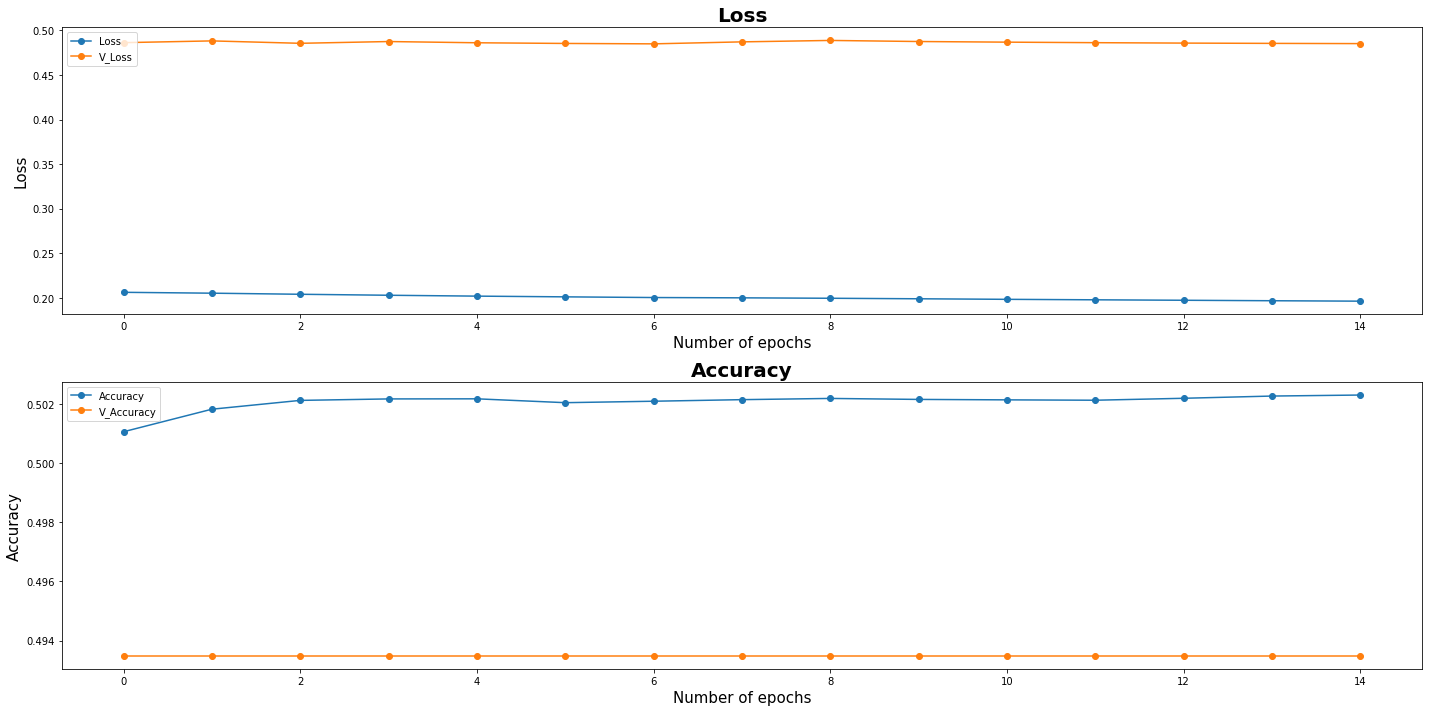

| Epoch [16] | Step [1889] | lr [0.000200] | Loss: [0.1718] | Acc: [0.5625] | Time: 0.2s
| Epoch [16] | Step [1890] | lr [0.000200] | Loss: [0.2388] | Acc: [0.5234] | Time: 0.2s
| Epoch [16] | Step [1891] | lr [0.000200] | Loss: [0.1839] | Acc: [0.4922] | Time: 0.2s
| Epoch [16] | Step [1892] | lr [0.000200] | Loss: [0.1719] | Acc: [0.4141] | Time: 0.2s
| Epoch [16] | Step [1893] | lr [0.000200] | Loss: [0.1884] | Acc: [0.5078] | Time: 0.2s
| Epoch [16] | Step [1894] | lr [0.000200] | Loss: [0.1884] | Acc: [0.5156] | Time: 0.2s
| Epoch [16] | Step [1895] | lr [0.000200] | Loss: [0.1944] | Acc: [0.5234] | Time: 0.2s
| Epoch [16] | Step [1896] | lr [0.000200] | Loss: [0.1943] | Acc: [0.5000] | Time: 0.2s
| Epoch [16] | Step [1897] | lr [0.000200] | Loss: [0.1791] | Acc: [0.5156] | Time: 0.2s
| Epoch [16] | Step [1898] | lr [0.000200] | Loss: [0.1857] | Acc: [0.4922] | Time: 0.2s
| Epoch [16] | Step [1899] | lr [0.000200] | Loss: [0.2086] | Acc: [0.4922] | Time: 0.2s
| Epoch [16] | Step [

| Epoch [16] | Step [1983] | lr [0.000200] | Loss: [0.1895] | Acc: [0.5391] | Time: 0.1s
| Epoch [16] | Step [1984] | lr [0.000200] | Loss: [0.1924] | Acc: [0.5625] | Time: 0.1s
| Epoch [16] | Step [1985] | lr [0.000200] | Loss: [0.1682] | Acc: [0.4609] | Time: 0.1s
| Epoch [16] | Step [1986] | lr [0.000200] | Loss: [0.1824] | Acc: [0.5312] | Time: 0.1s
| Epoch [16] | Step [1987] | lr [0.000200] | Loss: [0.1953] | Acc: [0.5078] | Time: 0.1s
| Epoch [16] | Step [1988] | lr [0.000200] | Loss: [0.1821] | Acc: [0.4922] | Time: 0.1s
| Epoch [16] | Step [1989] | lr [0.000200] | Loss: [0.1755] | Acc: [0.4766] | Time: 0.1s
| Epoch [16] | Step [1990] | lr [0.000200] | Loss: [0.1972] | Acc: [0.5703] | Time: 0.1s
| Epoch [16] | Step [1991] | lr [0.000200] | Loss: [0.1882] | Acc: [0.4766] | Time: 0.1s
| Epoch [16] | Step [1992] | lr [0.000200] | Loss: [0.1767] | Acc: [0.4844] | Time: 0.1s
| Epoch [16] | Step [1993] | lr [0.000200] | Loss: [0.1817] | Acc: [0.5156] | Time: 0.1s
| Epoch [16] | Step [

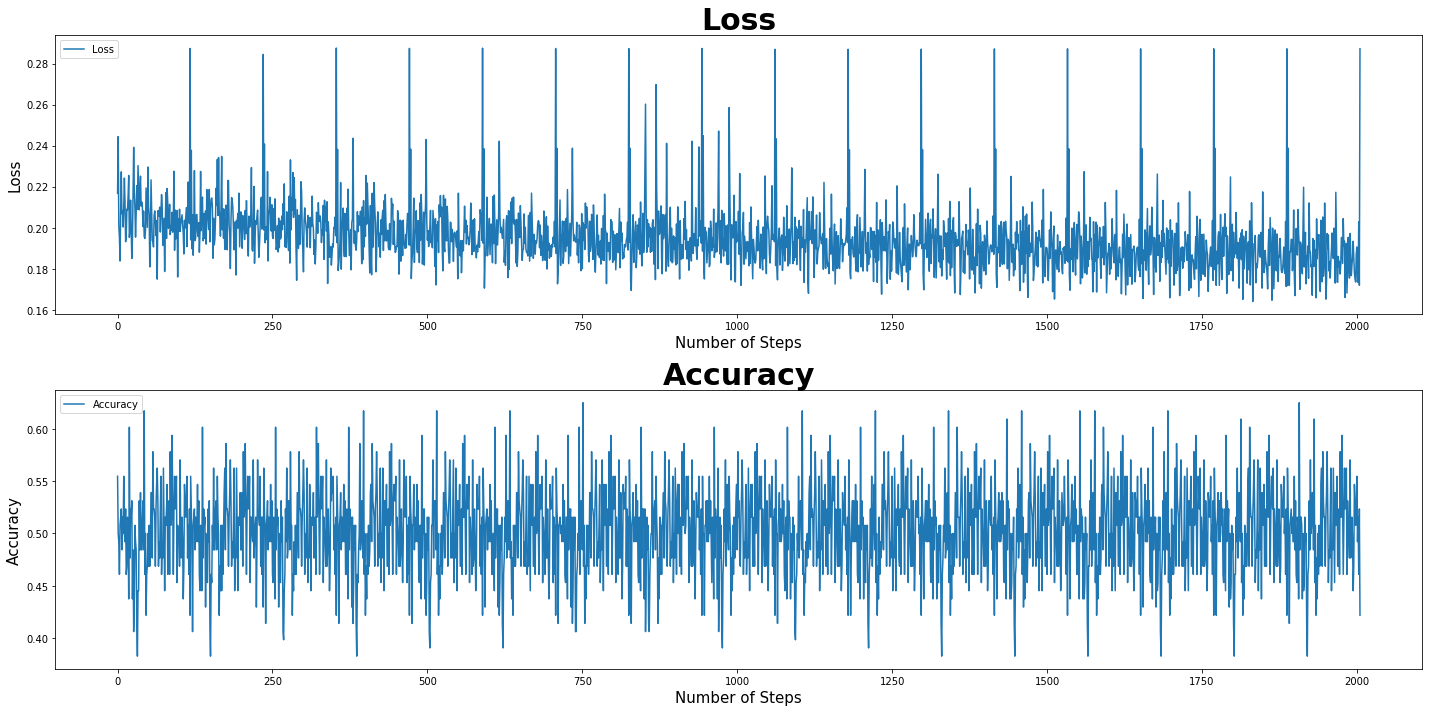

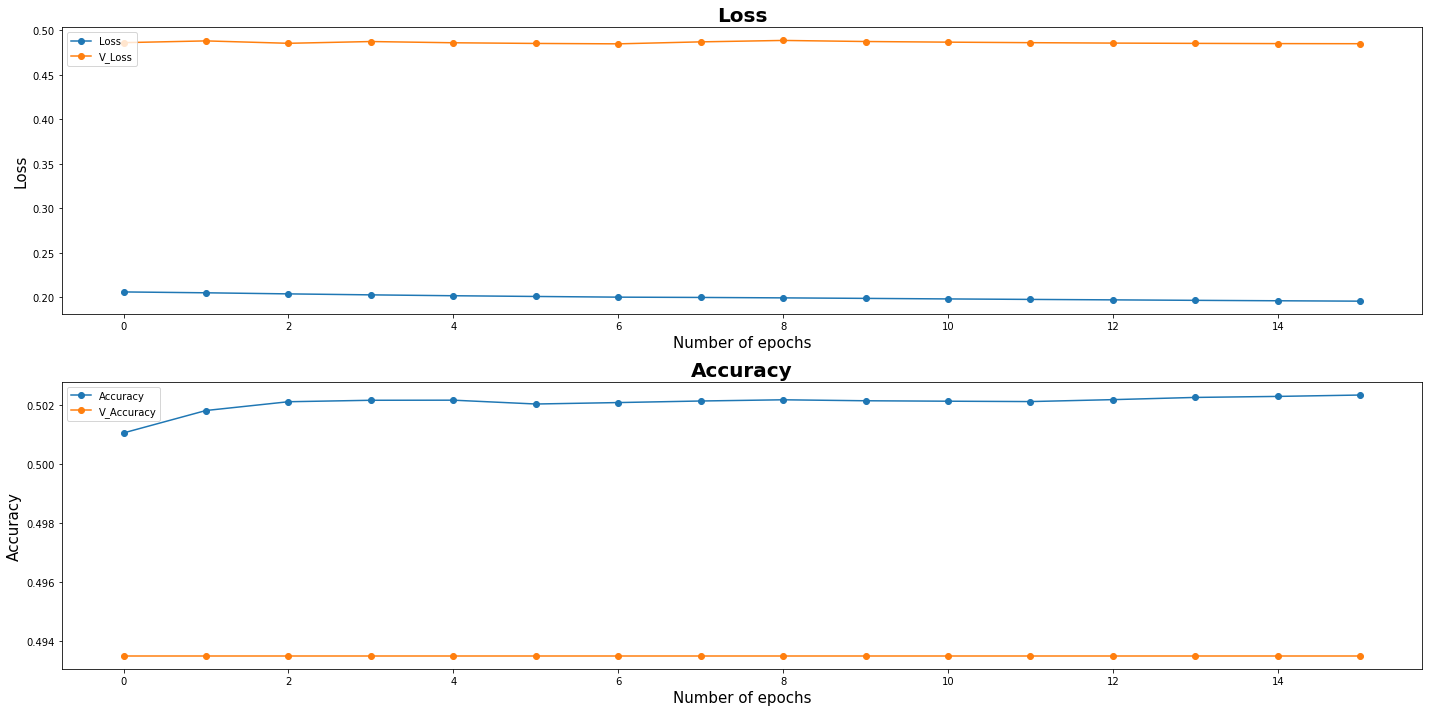

| Epoch [17] | Step [2007] | lr [0.000200] | Loss: [0.1755] | Acc: [0.5625] | Time: 0.2s
| Epoch [17] | Step [2008] | lr [0.000200] | Loss: [0.2388] | Acc: [0.5234] | Time: 0.2s
| Epoch [17] | Step [2009] | lr [0.000200] | Loss: [0.1764] | Acc: [0.4922] | Time: 0.2s
| Epoch [17] | Step [2010] | lr [0.000200] | Loss: [0.1754] | Acc: [0.4141] | Time: 0.2s
| Epoch [17] | Step [2011] | lr [0.000200] | Loss: [0.1882] | Acc: [0.5078] | Time: 0.2s
| Epoch [17] | Step [2012] | lr [0.000200] | Loss: [0.1887] | Acc: [0.5156] | Time: 0.2s
| Epoch [17] | Step [2013] | lr [0.000200] | Loss: [0.1938] | Acc: [0.5234] | Time: 0.2s
| Epoch [17] | Step [2014] | lr [0.000200] | Loss: [0.1893] | Acc: [0.5000] | Time: 0.2s
| Epoch [17] | Step [2015] | lr [0.000200] | Loss: [0.1793] | Acc: [0.5156] | Time: 0.2s
| Epoch [17] | Step [2016] | lr [0.000200] | Loss: [0.1833] | Acc: [0.4922] | Time: 0.2s
| Epoch [17] | Step [2017] | lr [0.000200] | Loss: [0.2047] | Acc: [0.4922] | Time: 0.2s
| Epoch [17] | Step [

| Epoch [17] | Step [2101] | lr [0.000200] | Loss: [0.1881] | Acc: [0.5391] | Time: 0.1s
| Epoch [17] | Step [2102] | lr [0.000200] | Loss: [0.1848] | Acc: [0.5625] | Time: 0.1s
| Epoch [17] | Step [2103] | lr [0.000200] | Loss: [0.1604] | Acc: [0.4531] | Time: 0.1s
| Epoch [17] | Step [2104] | lr [0.000200] | Loss: [0.1845] | Acc: [0.5312] | Time: 0.1s
| Epoch [17] | Step [2105] | lr [0.000200] | Loss: [0.1866] | Acc: [0.5078] | Time: 0.1s
| Epoch [17] | Step [2106] | lr [0.000200] | Loss: [0.1807] | Acc: [0.4922] | Time: 0.1s
| Epoch [17] | Step [2107] | lr [0.000200] | Loss: [0.1781] | Acc: [0.4922] | Time: 0.1s
| Epoch [17] | Step [2108] | lr [0.000200] | Loss: [0.1974] | Acc: [0.5703] | Time: 0.1s
| Epoch [17] | Step [2109] | lr [0.000200] | Loss: [0.1855] | Acc: [0.4766] | Time: 0.1s
| Epoch [17] | Step [2110] | lr [0.000200] | Loss: [0.1745] | Acc: [0.4766] | Time: 0.1s
| Epoch [17] | Step [2111] | lr [0.000200] | Loss: [0.1805] | Acc: [0.5234] | Time: 0.1s
| Epoch [17] | Step [

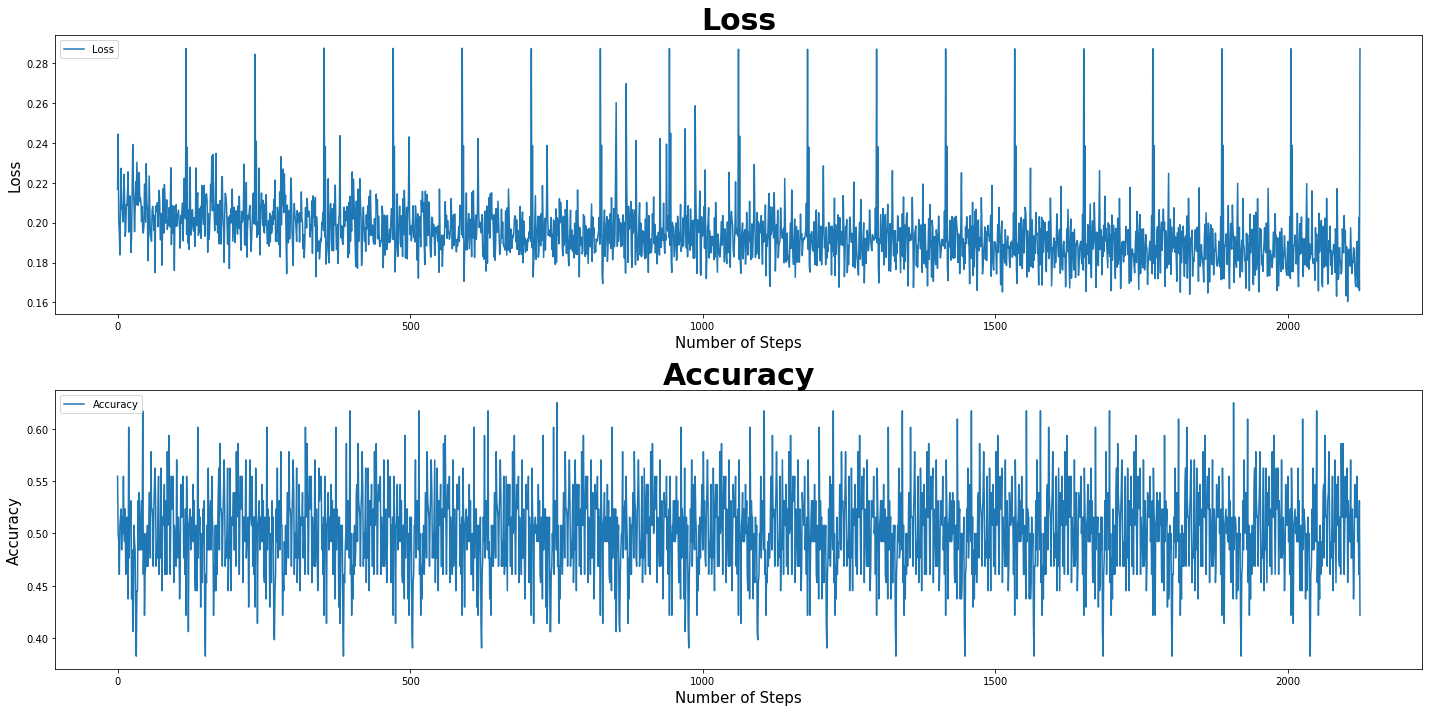

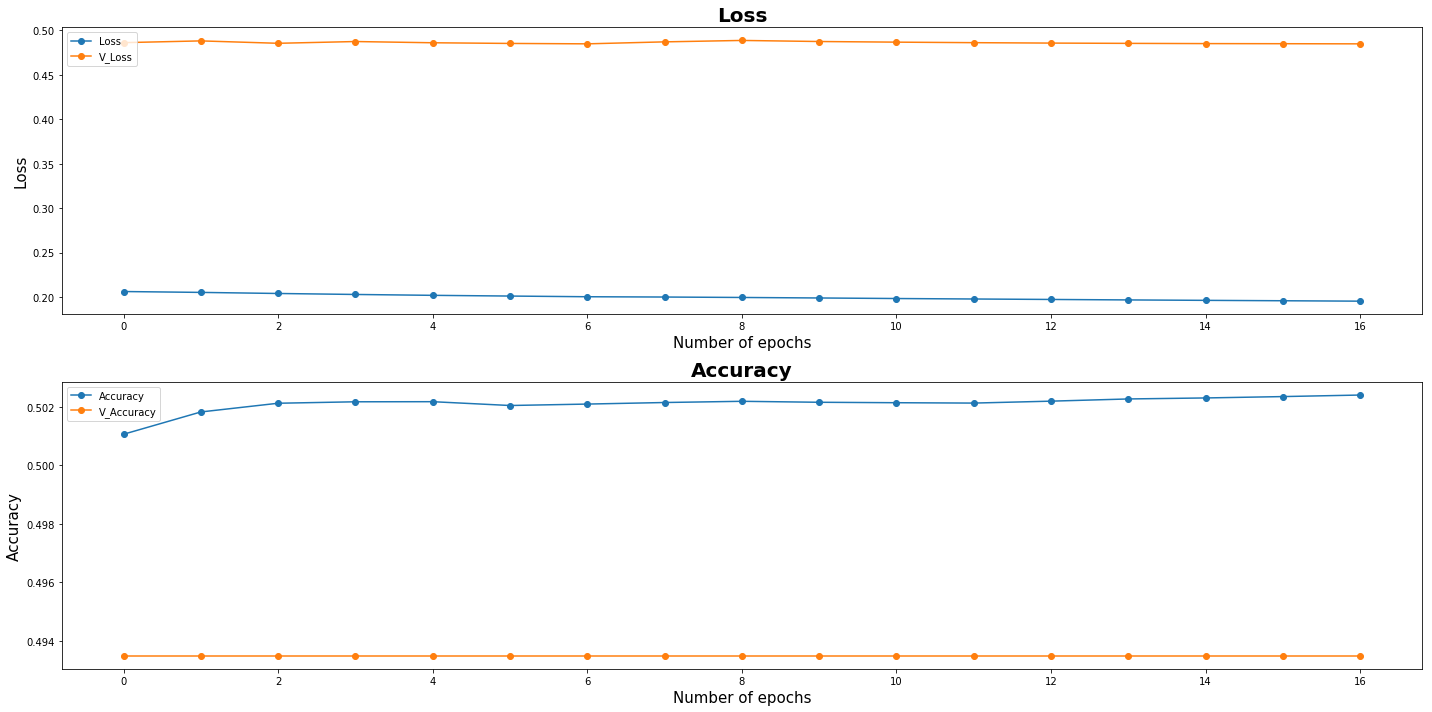

| Epoch [18] | Step [2125] | lr [0.000200] | Loss: [0.1702] | Acc: [0.5625] | Time: 0.2s
| Epoch [18] | Step [2126] | lr [0.000200] | Loss: [0.2389] | Acc: [0.5234] | Time: 0.2s
| Epoch [18] | Step [2127] | lr [0.000200] | Loss: [0.1774] | Acc: [0.5000] | Time: 0.2s
| Epoch [18] | Step [2128] | lr [0.000200] | Loss: [0.1717] | Acc: [0.4062] | Time: 0.2s
| Epoch [18] | Step [2129] | lr [0.000200] | Loss: [0.1879] | Acc: [0.5078] | Time: 0.2s
| Epoch [18] | Step [2130] | lr [0.000200] | Loss: [0.1843] | Acc: [0.5156] | Time: 0.2s
| Epoch [18] | Step [2131] | lr [0.000200] | Loss: [0.1896] | Acc: [0.5156] | Time: 0.2s
| Epoch [18] | Step [2132] | lr [0.000200] | Loss: [0.1846] | Acc: [0.5000] | Time: 0.2s
| Epoch [18] | Step [2133] | lr [0.000200] | Loss: [0.1810] | Acc: [0.5078] | Time: 0.2s
| Epoch [18] | Step [2134] | lr [0.000200] | Loss: [0.1787] | Acc: [0.5000] | Time: 0.2s
| Epoch [18] | Step [2135] | lr [0.000200] | Loss: [0.2033] | Acc: [0.4844] | Time: 0.2s
| Epoch [18] | Step [

| Epoch [18] | Step [2219] | lr [0.000200] | Loss: [0.1881] | Acc: [0.5469] | Time: 0.1s
| Epoch [18] | Step [2220] | lr [0.000200] | Loss: [0.1838] | Acc: [0.5625] | Time: 0.1s
| Epoch [18] | Step [2221] | lr [0.000200] | Loss: [0.1640] | Acc: [0.4531] | Time: 0.1s
| Epoch [18] | Step [2222] | lr [0.000200] | Loss: [0.1806] | Acc: [0.5234] | Time: 0.1s
| Epoch [18] | Step [2223] | lr [0.000200] | Loss: [0.1883] | Acc: [0.5078] | Time: 0.1s
| Epoch [18] | Step [2224] | lr [0.000200] | Loss: [0.1803] | Acc: [0.4922] | Time: 0.1s
| Epoch [18] | Step [2225] | lr [0.000200] | Loss: [0.1754] | Acc: [0.4844] | Time: 0.1s
| Epoch [18] | Step [2226] | lr [0.000200] | Loss: [0.1976] | Acc: [0.5703] | Time: 0.1s
| Epoch [18] | Step [2227] | lr [0.000200] | Loss: [0.1858] | Acc: [0.4688] | Time: 0.1s
| Epoch [18] | Step [2228] | lr [0.000200] | Loss: [0.1715] | Acc: [0.4844] | Time: 0.1s
| Epoch [18] | Step [2229] | lr [0.000200] | Loss: [0.1759] | Acc: [0.5078] | Time: 0.1s
| Epoch [18] | Step [

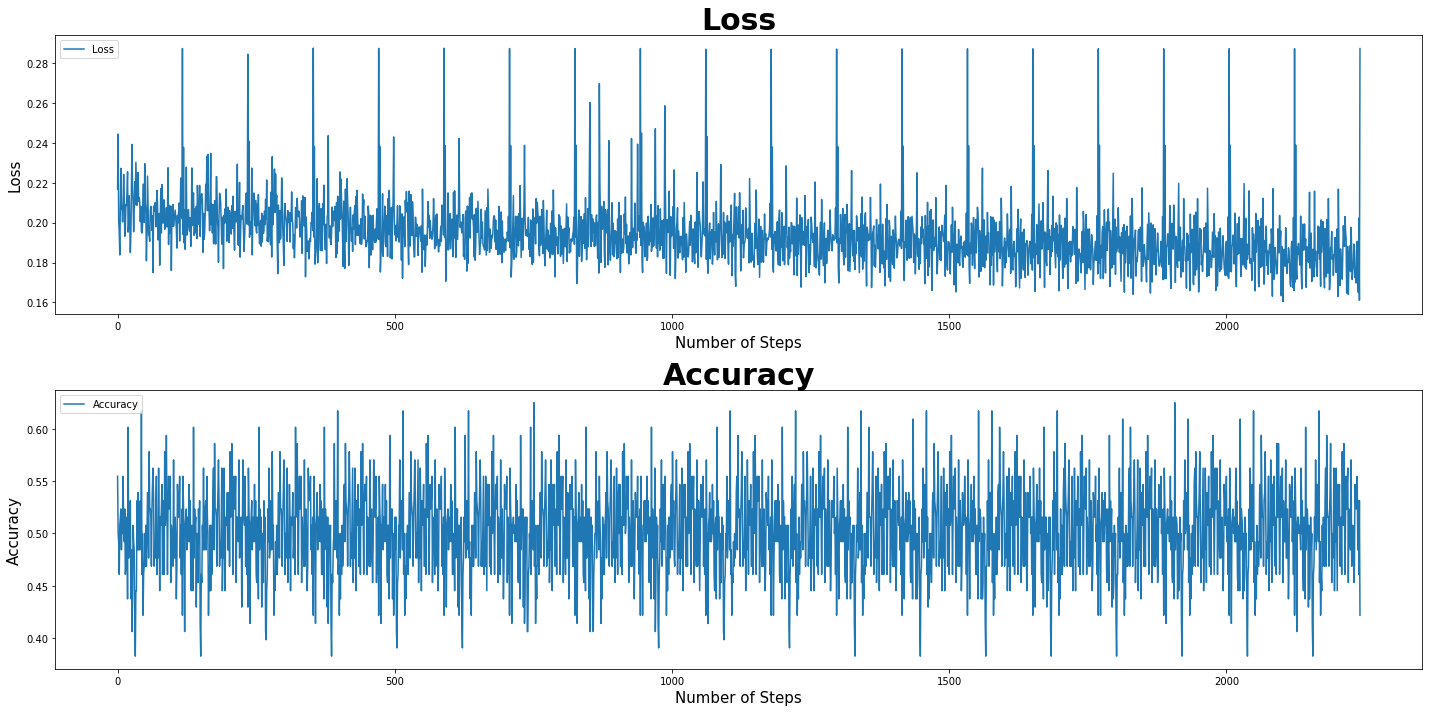

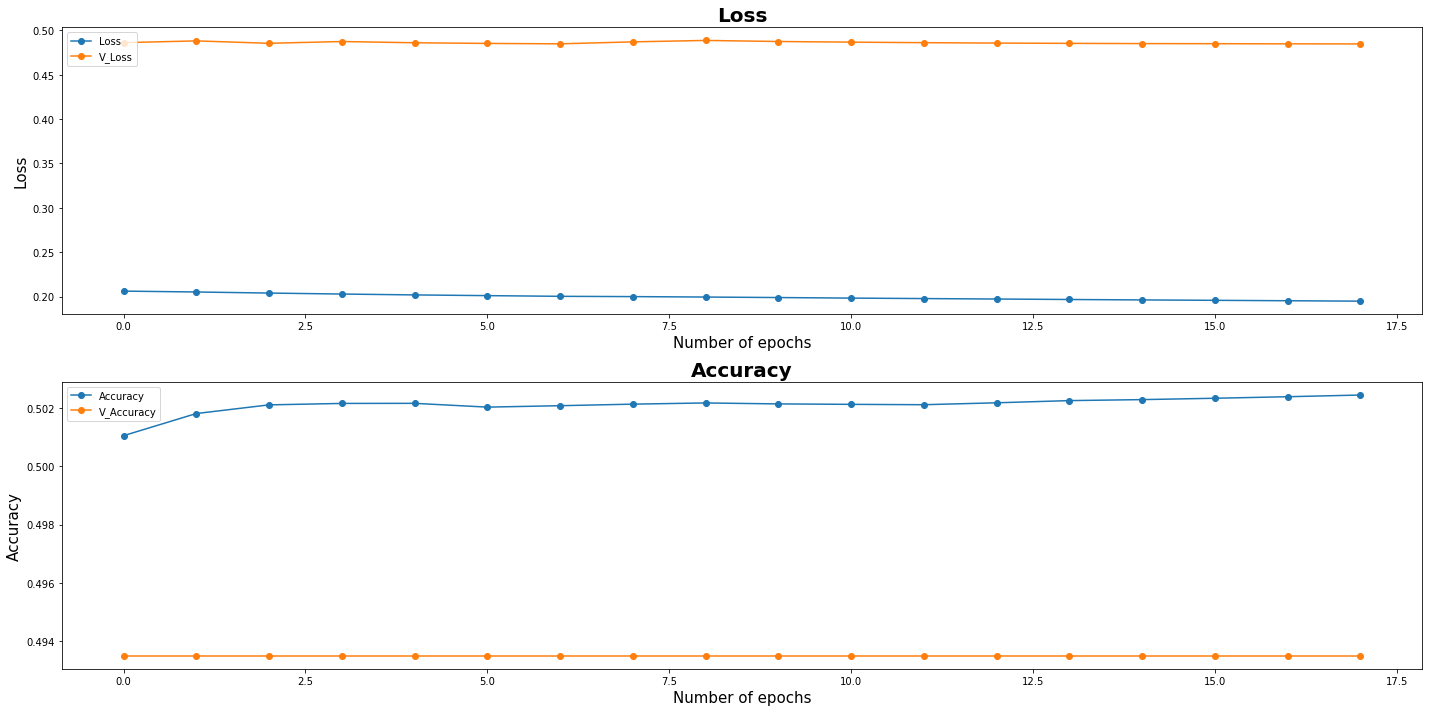

| Epoch [19] | Step [2243] | lr [0.000200] | Loss: [0.1678] | Acc: [0.5625] | Time: 0.2s
| Epoch [19] | Step [2244] | lr [0.000200] | Loss: [0.2389] | Acc: [0.5234] | Time: 0.2s
| Epoch [19] | Step [2245] | lr [0.000200] | Loss: [0.1740] | Acc: [0.5000] | Time: 0.2s
| Epoch [19] | Step [2246] | lr [0.000200] | Loss: [0.1749] | Acc: [0.4141] | Time: 0.2s
| Epoch [19] | Step [2247] | lr [0.000200] | Loss: [0.1875] | Acc: [0.5078] | Time: 0.2s
| Epoch [19] | Step [2248] | lr [0.000200] | Loss: [0.1866] | Acc: [0.5156] | Time: 0.2s
| Epoch [19] | Step [2249] | lr [0.000200] | Loss: [0.1886] | Acc: [0.5234] | Time: 0.2s
| Epoch [19] | Step [2250] | lr [0.000200] | Loss: [0.1840] | Acc: [0.5000] | Time: 0.2s
| Epoch [19] | Step [2251] | lr [0.000200] | Loss: [0.1826] | Acc: [0.5234] | Time: 0.2s
| Epoch [19] | Step [2252] | lr [0.000200] | Loss: [0.1772] | Acc: [0.4922] | Time: 0.2s
| Epoch [19] | Step [2253] | lr [0.000200] | Loss: [0.1998] | Acc: [0.5000] | Time: 0.2s
| Epoch [19] | Step [

| Epoch [19] | Step [2337] | lr [0.000200] | Loss: [0.1826] | Acc: [0.5469] | Time: 0.1s
| Epoch [19] | Step [2338] | lr [0.000200] | Loss: [0.1818] | Acc: [0.5625] | Time: 0.1s
| Epoch [19] | Step [2339] | lr [0.000200] | Loss: [0.1625] | Acc: [0.4531] | Time: 0.1s
| Epoch [19] | Step [2340] | lr [0.000200] | Loss: [0.1826] | Acc: [0.5234] | Time: 0.1s
| Epoch [19] | Step [2341] | lr [0.000200] | Loss: [0.1910] | Acc: [0.5078] | Time: 0.1s
| Epoch [19] | Step [2342] | lr [0.000200] | Loss: [0.1783] | Acc: [0.4922] | Time: 0.1s
| Epoch [19] | Step [2343] | lr [0.000200] | Loss: [0.1779] | Acc: [0.4766] | Time: 0.1s
| Epoch [19] | Step [2344] | lr [0.000200] | Loss: [0.1978] | Acc: [0.5703] | Time: 0.1s
| Epoch [19] | Step [2345] | lr [0.000200] | Loss: [0.1850] | Acc: [0.4766] | Time: 0.1s
| Epoch [19] | Step [2346] | lr [0.000200] | Loss: [0.1717] | Acc: [0.4766] | Time: 0.1s
| Epoch [19] | Step [2347] | lr [0.000200] | Loss: [0.1807] | Acc: [0.5078] | Time: 0.1s
| Epoch [19] | Step [

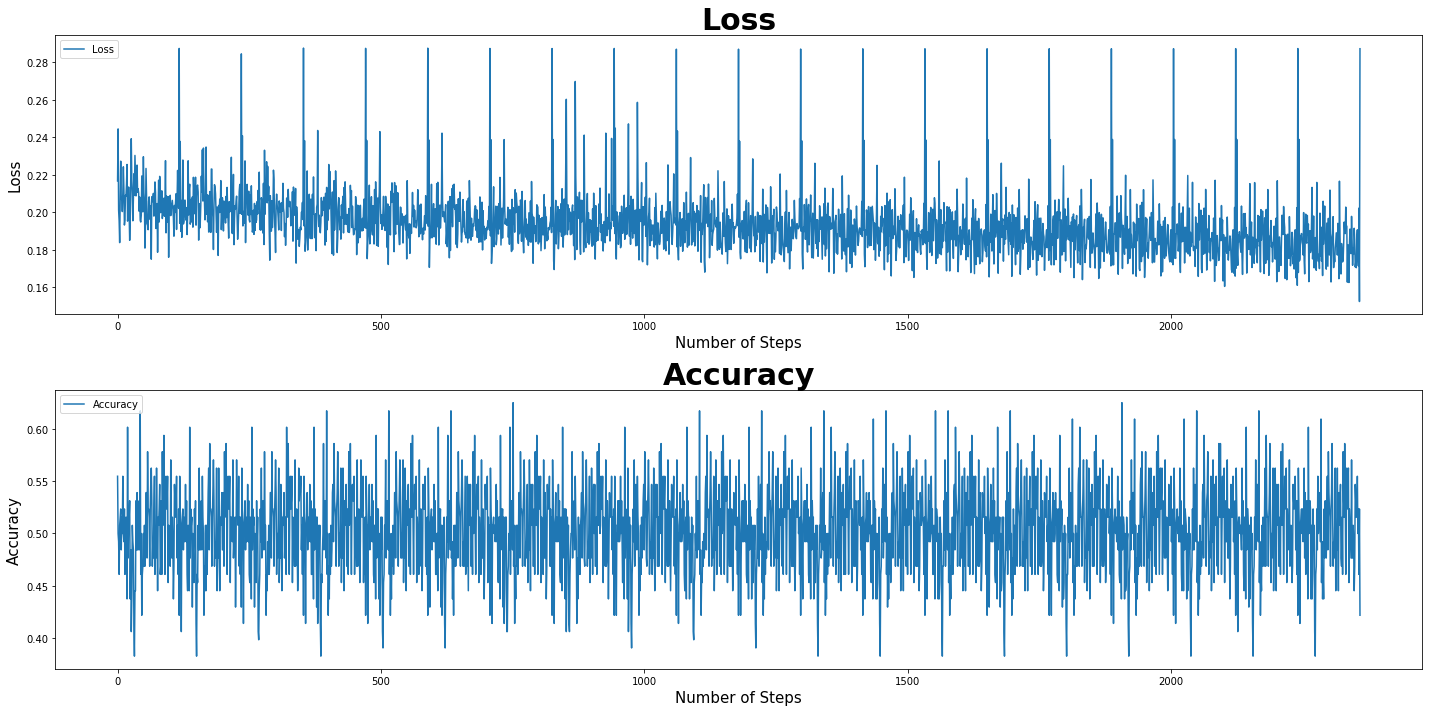

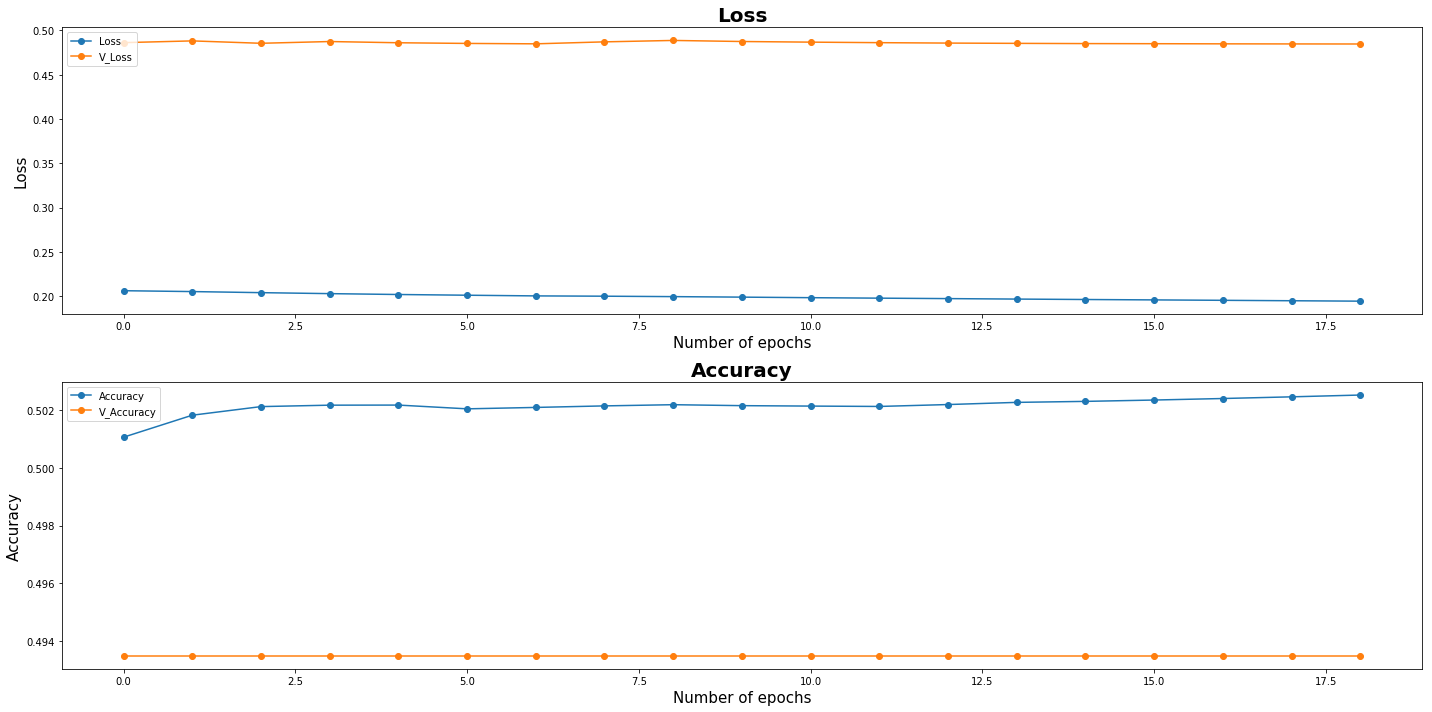

Model Saved


StopIteration: 

In [12]:
while epoch < args.n_epoch:
    siamese.train()
    for i, (left, left_len, right, right_len, y) in enumerate(train_loader):
        
        
#         scheduler.step()
        start_t = time.time()
        
        left = left.to(device)
        left_len = left_len.to(device)
        right = right.to(device)
        right_len = right_len.to(device)
        y = y.to(device)
        
        siamese(left, left_len, right, right_len, y)
        end_t = time.time()
        all_step += 1
        print('| Epoch [%d] | Step [%d] | lr [%.6f] | Loss: [%.4f] | Acc: [%.4f] | Time: %.1fs' %\
              ( epoch, all_step, siamese.optim.param_groups[0]['lr'], siamese.loss.item() , siamese.acc.item() ,
                end_t - start_t))
        
#         if siamese.acc.item() > 0.95: # Stop early
#             raise StopIteration
    
    if i % 1 == 0:
        siamese.eval()
        for j, (v_left, v_left_len, v_right, v_right_len, v_y) in enumerate(valid_loader):

            v_left = v_left.to(device)
            v_left_len = v_left_len.to(device)
            v_right = v_right.to(device)
            v_right_len = v_right_len.to(device)
            v_y = v_y.to(device)
            siamese.test_step(v_left, v_left_len, v_right, v_right_len, v_y)
            end_t = time.time()
            print('| Epoch [%d] | Validation | Step [%d] |  Loss: [%.4f] | Acc: [%.4f] | Time: %.1fs' %\
                  ( epoch, j, siamese.v_loss.item() , siamese.v_acc.item() ,end_t - start_t))
                
    siamese.plot_all_loss('Simplest_LSTM_Training_0reg')
    
    if epoch >= 1:
        plot_train_hist(train_hist, 'Simplest_LSTM_Training_0reg')

    for name in siamese.train_hist.keys():
        train_hist[name].append(sum(siamese.train_hist[name])/len(siamese.train_hist[name]))

    if not args.running_loss:
        for name in siamese.train_hist.keys():
            siamese.train_hist[name] = []
            
    epoch += 1
    
    if epoch % 10 == 0 and epoch != 0:
        siamese.model_save(epoch)
    
    if epoch >= 20:
        raise StopIteration

In [ ]:
##### This Algorithm can solve the problem and make the graph in a batch of training data #####

class Graph_Alg(object):
    
    def __init__(self,):
        self.G = nx.Graph()
    
    def forward(self, x, y):
        
        paired_data = np.array(x[y.byte()])
        for i in paired_data:
            for j in i:
                for k in range(len(j)):
                    if not j[k] in self.G.nodes:
                        self.G.add_node(j[k])
                    if k >= 1:
                        if not (j[k],j[k-1]) in self.G.edges:
                            self.G.add_edge(j[k],j[k-1])
                            
    def draw(self,):
        
        nx.draw(self.G, with_labels=True, font_weight='bold')
        plt.show()
        
    def test(self, x, y):
        
        out = []
        paired_data = np.array(x)
        
        for i in paired_data:
            out.append(self.check_step(i))
        match = list(np.array(out) == np.array(y).astype(int))
        self.acc = sum(match) / len(match)
             
    def check_step(self, i):
        
        # Check the path is in the graph
        for j in i:
            for k in range(len(j)):
                if not j[k] in self.G.nodes:
                    return 0
                if k >= 1:
                    if not (j[k],j[k-1]) in self.G.edges:
                        return 0
                        
        # Check the the pair is possible to have the same st_node   
        for node in list(self.G.adj[i[0][0].item()]):
            if node in list(self.G.adj[i[1][0].item()]):
                return 1

        return 0


In [ ]:
graph_algo = Graph_Alg()
algo_train_hist = defaultdict(list)
num_steps = 20
for i in range(num_steps):
    data, label = iter(train_loader).next()

    # Training
    graph_algo.forward(data, label)
    
    # Testing
    v_data, v_label = iter(valid_loader).next()
    graph_algo.test(v_data, v_label)
    algo_train_hist['Accuracy'].append(graph_algo.acc)
    
plot_train_hist(algo_train_hist, 'Graph_algo')
graph_algo.draw()